# What are the common activities that the victims were engaged in prior to the accident?

In [176]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import xlsxwriter

# List Of Category indexes as per stated in the CA document

In [177]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

# Classes to store the category and case items together with helper functions

In [178]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, str(len(self.ActivityTokensVerb)) , str(len(self.ActivityTokensChunk))))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

# Read from and write to excel, populate case items, intialization of categories

In [179]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    global OshaCasesDF
    global MsiaCasesDF
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaCasesDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # Note MsiaCases only summary case but Osha has description
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column, 
    for index,row in OshaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title'], row['Description'], row['Cause'], GetCategoryIndex(row['Cause']))
        OshaCaseItems.append(TempCaseItem)

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    global OshaCategories
    MsiaCategories = []
    OshaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)
        OshaCategories.append(tempcat)
        
def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it
    
def WriteToExcel(filename, SelectedCaseItemsDF):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    # Convert the dataframe to an XlsxWriter Excel object.
    SelectedCaseItemsDF.to_excel(writer, sheet_name='Sheet1')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()    

# Visualisation function to plot frequency distribution, word cloud and list some of the common activities

In [180]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def VisualisationAll(SelectedCases):   
    tokens_clean_single = []
    for item in SelectedCases:
        if (len(item.ActivityTokensVerb)>0):
            # frequecy distribution chart
            for tok1 in item.ActivityTokensVerb:
                tokens_clean_single.append(tok1)
    fd = nltk.FreqDist(tokens_clean_single)
    fd.most_common(25)
    TopActivityTokens = fd.most_common(5)
    fd.plot(25)
    print("Total count for this dataset is " + str(len(tokens_clean_single)))
    #print(tokens_clean_single)
    #print(TopActivityTokens)

    # ==== Installation of wordcloud package
    # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
    # 2. Copy the file to your current working directory
    # 3. Open command prompt from Tools
    # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl

    # 1. Simple cloud
    # Generate a word cloud image
    # Take note that this function requires text string as input
    # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
    wc = WordCloud(background_color="white")
    wc.generate_from_frequencies(fd)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()    
    print("\n")

In [181]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def Visualisation(category):   
    #tokens = word_tokenize(text)
    if (len(category.ActivityTokensVerb)>0):
        # frequecy distribution chart
        print(category.Name)
        #tokens_clean = [ t for t in category.ActivityTokensVerb if len(t) >= 3 ]
        tokens_clean_single = []
        for tok1 in category.ActivityTokensVerb:
            for tok2 in tok1:
                tokens_clean_single.append(tok2)
        fd = nltk.FreqDist(tokens_clean_single)
        fd.most_common(25)
        TopActivityTokens = fd.most_common(5)
        fd.plot(25)
        print("Total count for this category is " + str(len(tokens_clean_single)))
        #print(tokens_clean_single)
        #print(TopActivityTokens)
        
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(fd)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()    
        
        chunks_limit = 10
        print("Top 5 activity word and their sentences")
        print("=======================================\n")
        for word in TopActivityTokens:
            chunks_count = 0
            underline = ""
            print('\n' + word[0])
            for c in word[0]:
                underline += '='
            print(underline + '\n')
            #Populate sentences belonging to top tokens
            for chunk1 in category.ActivityTokensChunk:
                for chunk2 in chunk1:
                    chunk_token = nltk.sent_tokenize(chunk2)
                    chunk_lemma_token = get_lemma(chunk_token)
                    #print(chunk_lemma_token)
                    #chunk_text = ' '.join(chunk)
                    if len(chunk_lemma_token) >= 1:
                        #print (chunk_lemma_token)
                        for token in chunk_lemma_token:
                            if word[0] in get_lemma_word(token.split(' ')[0]):
                                if (chunks_count < 10):
                                    print(chunk2)
                                chunks_count += 1

            print("\n")
    else:
        print("Visualisation Function : NO DATA AVAILABLE")



# Text Mining helper functions 
- get_lemma - lemmatizer to get the base word based on speech tag
- get_stem - similar to get_lemma but some of the base words are not correct, so I did not use this
- get_verb_count - returns number of verb word found in the sentence
- filter_off_unwanted chunks - custom filter to more accurately extract verb associated with the activities

In [182]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_lemma_word(text):
    return WNlemma.lemmatize(text, 'v')

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have', 'wear', 'use', 'work', 'exist', 'remain', 'include', 'experience','come','contain','ensue','crush','miss','receive']
    filter_all_words = ['carry out work', 'fly object']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['kill','carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in ' '.join(get_lemma(untag(subtree))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in ' '.join(get_lemma(untag(subtree))) ):
            print (faw)
            return False, subtree
    if get_verb_count(untag(subtree)) > 0:  
        return True, subtree
    else: 
        return False, subtree

def clean_up_chunk(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    text = text.replace(' ','')
    return text

# Main function to extract the activities sentences and verb
- 1st loop (ie. OCC1) is used for extracting the sentences containing the activities. The RegexpParser will look for verb in past tenses(VBD), base form(VB), past participle(VBN), present participle(VBG) etc that is constructed together with nouns(singular, plural, proper noun,) as well as preposition(IN), adjective(JJ), particle(PR).

- 2nd loop (ie. OCC2) is used to further extract the base verb that is found using OCC1.

In [183]:
def extract_activities_chunk_and_verb(text):
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """

    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = []
    ExtractedActivitiesVerb = []
    if (not text=="") and (len(text) >= 3):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_chunk(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_chunk(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk.append(token_chunk_clean_str)
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb.append(clean_up_verb(str(tokens_verb_lem_clean)))
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

# Main Loop
- Initializes the case and categories item
- create the lemmatizer and stemmer objects
- read from excel and populate the case and categories

In [184]:
# Initialize     
MsiaCategories = []
MsiaCaseItems = []
MsiaCasesDF = []
OshaCategories = []
OshaCaseItems = []
OshaCasesDF = []

MsiaCasesFile = 'MsiaAccidentCases.xlsx'
#the Osha case file must have the causes populated by the predictor model developed by Vincent
OshaCasesFile = 'osha1.xlsx'

#NLTK Objects
# lemmatize to convert to base words depending on speech tagging
WNlemma = nltk.WordNetLemmatizer()
# stemmer to get the base words
Stemmer = nltk.SnowballStemmer('english')   

#Initilize categories
InitializeCategories()
#Read data from excel and populate case items
ReadFromExcelAndPopulateCase()

# Flags to determine which data set to use. 
- ProcessMsiaDataSet for Msia Dataset
- ProcessOshaDataSet for Osha Dataset

In [185]:
# if False, means process the Osha dataset
ProcessMsiaDataSet = False
ProcessOshaDataSet = True

# Main Processing Section 1
- Loops through each case item then populate the activities sentences and verb token 

In [159]:
if ProcessMsiaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in MsiaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in MsiaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

installing wood plate(1)
carrying the job of binding Reinforcement Steel Cage(2)
climbing up the cage(1)
performing cable pulling job(2)
opening the clutch door(1)
dismantling Shear Wall(1)
carry out work
controlling the traffic(1)
entering the room(1)
move the box containing foods(1)
moving forklift(1)
carrying mold installation(1)
stepping on the hollow section(1)
replacing the bricks(1)
wrapping plastic tubing(2)
breaking the stone(1)
lying on the floor(1)
cutting down trees(1)
lifting a bundle(1)
cutting down trees(1)
lifting a pile(1)
lift the lifting tray(1)
removing the glass door(1)
tagging the name(1)
standing on plywood plate(1)
carry out binding(1)
lifting lug(1)
lifting works using Overhead Travelling Crane(3)
cutting the oil palm fruit(1)
knitting the oil palm fruits(1)
driving mechanical buffalo(1)
dismantling the top structure(1)
climbing the scaffolding(2)
driving downhill(1)
standing on the drawbar trailer(1)
lifting the drain block(1)
carrying road leveling work using

In [186]:
if ProcessOshaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in OshaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in OshaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

operating a forklift(1)
moving bales(1)
replacing an air filter(1)
specializing in fiber(1)
marking the location(1)
performing the duties(1)
travelling in the travel/through lane(1)
offloading hot brine water(1)
switching the truck(1)
let go causing the hot brine water(1)
running toward the control room(1)
transferring soup(1)
cutting the seal(1)
pulling a knife(1)
placing on the knife(1)
stabbing type(1)
operating a rough terrain forklift(1)
positioning the forklift(1)
pulling a cart(1)
making turns(1)
turning cart(1)
installing vinyl sidings(1)
standing an A-frame ladder(1)
Using the table(1)
ripping the piece(1)
ripping the second board Employee(1)
cutting a third piece(1)
alleging violation(1)
ripping pieces(1)
transferring product(1)
operating an asphalt-pulverizing machine(2)
cleaning the interior(1)
standing in front(1)
inspecting the 21000-volt pad(1)
idling Caterpillar D8K track bulldozer(1)
lowering the unit(1)
kneeling on the bulldozer(1)
insert nails into roofing tiles(1)
w

scrubbing the floor(1)
removing safety brackets(1)
supporting the trellis(1)
connecting the trellis(1)
connecting the trellis(1)
cutting a pipe(1)
cutting the well(1)
casing igniting an unknown substance(2)
cutting the well casing(2)
welding gloves(1)
break the concrete lining(1)
separating the pipe(1)
sling hooks(1)
sustaining severe injuries(1)
removing the roof(1)
cutting torch(1)
sorting out different types(1)
turning on the acetylene(1)
adjusting the torch(1)
connecting the hose(1)
cutting torch(1)
burning both men(1)
cutting torch(1)
lowering the lift(1)
utilizing an oxygen-acetylene torch(1)
utilizing the torch(1)
sitting on the opposite front tire(1)
holding a piece(1)
entering the engine(1)
cutting torch(1)
watching out for any fires(1)
standing in front(1)
servicing tractor discs(1)
cutting tip(1)
catching the acetylene lead(1)
welding a new section into the existing pipeline(2)
standing in an excavation(1)
sitting in the excavator(1)
consisting of bentonite(1)
cutting torch(

performing a brake work on paving truck Number(2)
replacing the first air line(1)
ringing in both ears(1)
inflating a tire(1)
releasing chlorine(1)
leaving the plant(1)
breathing air(1)
attaching the airlines(1)
specializing in building docks(2)
installing fender panels(1)
protruding portion(1)
striking the water(1)
sandblasting a precast panel(1)
carrying the liquid coolant(1)
diving operations(1)
turning under the torque(1)
overseeing the job(1)
communicating on the headset(1)
monitoring the breathing air(2)
breathing air(1)
sandblasting stainless steel(1)
sandblasting stainless steel heating coils(2)
painting a bulldozer(1)
suffering from pneumonia(1)
participating in a training drill(2)
decontaminating hazardous materials response members(1)
utilizing Self Contained Breathing Apparatus(2)
breathing air(1)
drawing air(1)
splitting the compressor(1)
breathing air(1)
attaching a hook(1)
breathing air(1)
breathing air(1)
coupling into the nitrogen supply(1)
breathing pure nitrogen(1)
m

landing coming down the marble stairs(2)
staying at the hotel(1)
jumping from the front(1)
utilizing a high-pressure water hose(1)
loading tobacco(1)
drinking beer(1)
directing traffic(1)
lighting traffic signs(1)
traveling southbound(1)
programming the transmitters(1)
treating inmates(1)
tipping the drum(1)
spilling alcohol(1)
grinding a small metal disk(1)
spilling the alcohol(1)
grinding in a direction(1)
running the grinder(1)
cleaning with a rag(1)
drinking alcohol(1)
sleeping on a couch(1)
fighting the fire using hand(2)
hitting the ledge(1)
separating the glass(1)
separating the glass(1)
following the accident(1)
submit training documents(1)
indicating that Employee(1)
visiting on the day(1)
investigating the cause(1)
spraying an alcohol-based primer(1)
installing reinforcing bars(2)
installing rigging equipment(2)
sliding device(1)
climbing pegs(1)
loading from spills(1)
observe anything(1)
driving home(1)
think anything(1)
swelling allergic reactions(1)
sleeping quarters(1)
sl

removing an anhydrous ammonia tank(1)
standing behind Employee(1)
entering the corridor Employee(1)
filling a nurse tank(1)
lying on the ground(1)
disconnecting the hose(1)
filling the nurse tank Employee(1)
hooking the tank(1)
expanding boiling-liquid blast(1)
replacing a solenoid valve(1)
heating unit(1)
ammonia during the evacuation(1)
leaking during an anhydrous ammonia system repair(2)
landscaping for Greenridge Landscaping Inc.(2)
landscaping the area(1)
feeding the lions(1)
pulling a cap(1)
restraining a cat(1)
clipping Star Jasmine ground cover(1)
clipping the leaves with trimming shears(2)
driving back a dump truck(1)
weed cutting activity(1)
driving a three-Axel FORD ID Number EQ2063 Heavy Dump Truck(1)
driving the truck(1)
parking the dump truck(1)
regarding an injured alligator(1)
extracting a dog(1)
lowering the tailgate(1)
thinning grapevine leaves(1)
performing crowd control duties(1)
climbing a stair(1)
trimming the toenails(1)
trimming the nails(1)
monitoring dogs(1)
p

directing the first driver(1)
Paling Trucking with a dump load(2)
standing on the ground(1)
standing near the rear driver(1)
burning wood waste(1)
cleaning the material(1)
standing on a ladder(1)
cleaning fly ash(1)
dislodging ash(1)
clearing a large mass(1)
opening burning Employees(2)
flowing through the duct(1)
enveloping everyone(1)
evacuating the area(1)
walking in ashes(1)
holding the nozzle(1)
directing the water stream(1)
holding the hosepipe(1)
operating a Case skid steer loader(1)
raise a hopper containing(1)
preparing a boiler(1)
cooling Employee(1)
standing outside the hopper(1)
cleaning the hopper(1)
scaffolding company(1)
building a scaffold(1)
testing in order(1)
checking the hopper(1)
looking at the door(1)
standing on the ground(1)
checking the depth(1)
checking the cut(1)
controlling the operation(1)
ensuring that the milling machine(2)
waiting for PSI(1)
milling machine(1)
hitting the reflectors(1)
oncoming vehicle(1)
warning lights(1)
spacing tapering attenuators(2)

moving components(1)
repairing the problem(1)
adjusting the sensor(1)
opening a relay switch(1)
completing the repair(1)
ring finger(1)
assessing a problem(1)
loading arm(1)
loading a wrecked car(1)
standing at the hoist controls(1)
operating a trim press(1)
reset a spring(1)
reaching in the machine(1)
performing machine adjustments(1)
contributing factors(1)
building a truck bed(1)
lifting points(1)
lifting points(1)
manufacturing ceramic parts(1)
compacting press(1)
interlocking glass doors(1)
warning signs(1)
standing on the shoulder(1)
holding the base(1)
striking Employee(1)
driving a truck(1)
getting some gasoline(1)
approaching motorist(1)
driving off the line(1)
shooting the fuel injection system(1)
trigging the fire(1)
performing clean up duties after mowing operations(2)
grabbing the skidding line(2)
hanging from a carryage car(1)
running on the main line(1)
striking the squad car(1)
hitting the squad car(1)
standing on the chassis frame(1)
drawing fuel(1)
climbing an automob

driving an aircraft belt loader(1)
trapping Employee(1)
walking out of the bag room(1)
loading baggage(1)
moving inner blades(1)
changing the starter(1)
pulling baggage containers(1)
entering the unloading area(2)
placing luggage onto a moving conveyor belt(2)
pulling the strap(1)
shutting off the conveyor(1)
rattling sound(1)
switching off the machine(1)
marshaling in tugs(1)
dropping the locks(1)
moving the containers(1)
concerning the practice(1)
lowering the locks(1)
cleaning the interior parts(1)
placing a box(1)
placing a bakery rack(1)
loading dock(1)
manufacturing bread rolls(1)
pulling bread racks(1)
specializing in the production(1)
moving equipment(1)
moving a cart containing bagel boards(2)
adjoining edges(1)
pulling the cart(1)
troubleshooting a Templex Automatic Rack Proofer(1)
moving the rack(1)
walking backwards(1)
pulling the rack(1)
loading sourdough bread(1)
positioning the ramp(1)
transporting dough(1)
haul the metal cart containing metal pans(1)
clearing a jammed p

starting the ignition(1)
starting the buses(1)
starting battery(1)
charging all night(1)
opening the unit(1)
ventilate the battery-holding chamber(1)
siphoning gasoline(1)
igniting flammable vapors(1)
sending flames(1)
burning Employee(1)
approaching the angle iron barrier(1)
charging station(1)
turning the right rotating hand grip upward(2)
charging rack(1)
braking method(1)
lowering the control handle(1)
operating manual plugging(2)
reversing the direction(1)
traveling causing the unit(2)
moving an electric stand-up pallet jack(1)
striking Employee(1)
touching a metal rack(1)
contributing factor(1)
heading toward the exit door(1)
burning gas(1)
backing up a Raymond(1)
erecting steel beams(1)
connecting beams(1)
walking on top(1)
holding a metal beam bar(1)
letting the end(1)
traveling in a reverse direction(1)
lifting the foot(1)
keeping arms(1)
driving a debris truck(1)
knocking the beam(1)
performing exterior carpentry(1)
providing support(1)
striking Employees(1)
measuring the bea

cleaning the dough dividing machine(2)
standing on a platform(1)
jogging mode(1)
cleaning hoppers(1)
driving the train(1)
closing the superstructure(1)
creating a pinch point(1)
tapping the Number(1)
inspecting the sub ladle(1)
training another employee(1)
pouring molten lead(1)
walking along the south side(1)
observe the pouring operation(1)
glowing bricks(1)
charging the rocker furnace(1)
cooling from the previous pour(1)
adding the last load(1)
seeing a brief flame(1)
collapsing wall(1)
combining incompatible materials(1)
standing on a 36-inch diameter(1)
operating a Daewoo excavator(1)
breaking concrete(1)
breathing difficulties(1)
injuring Employees(1)
operating a rubber tire loader(1)
stalling the engine(1)
charging platform(1)
blowing out of a blast furnace(1)
charging platform(1)
informing anyone(1)
supervising the blasting(2)
blasting rock(1)
excavate building sites(1)
undergoing numerous surgeries(1)
removing the filter canisters(1)
discharging ABC(1)
discharging fire extingu

unwinding the yarn onto the rotating metal(2)
roving machine(1)
standing at a wire rope(1)
cutting torch(1)
repairing the leak(1)
cleaning up the leaking oil(2)
cleaning up the leaking oil(2)
repairing a blow(1)
unjamming a boiler(1)
flying debris(1)
bringing a firetube boiler(1)
performing an annual inspection(1)
leaking on the boiler(1)
tightening the last handhole cover(1)
flow out of the opening(1)
install a new flue liner for an existing boiler(1)
cleaning beneath the tail(1)
allowing contact(1)
dismantling a scaffold(1)
moving toward the area(1)
walking on the platform planks(1)
triggering an explosion(1)
flying debris(1)
restarting the B28 boiler(1)
looking through the sight glass(1)
performing nondestructive testing(2)
scaffolding inside of the boiler tube cavity(1)
covering the opposite wall(1)
congealing on the wall(1)
leaking oil(1)
heating boilers(1)
heating boilers(1)
sitting on the floor(1)
leaning against a box(1)
heating boilers(1)
troubleshooting following the accident

setting machine(1)
tagging out the equipment(1)
setting bed(1)
setting bed(1)
clearing a jam(1)
bowling pin machinery(1)
cutting across the Employee(1)
operating a rotary slitter/scorer machine(1)
rolling the full cart(1)
cleaning up boxes(1)
passing a long box(1)
following the accident(1)
installing communications vaults(1)
putting the lid(1)
activating the transition feed rollers(1)
strapping machine area(1)
suffering multiple internal injuries(1)
closing the lid(1)
pulling the cover(1)
wiring in Long Beach(1)
hitting the cover Employee(1)
contemplating changing/designing a new tool(2)
pulling the tops(1)
installing new sheet metal(1)
covering the opening(2)
striking the back(1)
reordering a freight(1)
reordering the books(1)
unloading a rail car(1)
unstacking the boxes(1)
unstacking the boxes(1)
riding on a railcar(1)
preparing a railcar(1)
bleeding from a head wound(1)
dumping station(1)
regulating the speed(1)
dumping station(1)
loading a railroad box car(1)
loading dock(1)
loadin

operating a bridge crane(1)
removing tension(1)
standing on the steel plate(1)
placing a plywood screen(1)
placing bridge girders(1)
positioning the aerial lift(1)
landing beams(1)
operating a spiral machine(1)
running smooth steel wire(1)
guiding the tail end(1)
moving rolls(1)
securing PVC pipe(1)
lowering a 50-ft-long form(1)
vacuuming a platform(1)
creating a hole(1)
building a rebar form(1)
tying in a 94-ft-long piece(1)
operating the industrial truck(1)
building a form(1)
placing deadman(1)
shifting from the collapse(1)
tying 30-ft sections(1)
assisting with the construction(1)
assisting with the correct placement(1)
lowering the beam(1)
exiting the aerial basket(1)
demolishing a bridge section(1)
supporting members(1)
assisting as a crane(1)
piling bracket(1)
rigging foreman(1)
standing on top(1)
installing tarpaulin(1)
passing motor vehicles(1)
driving a tractor(1)
pulling a compactor(1)
Somehow the rig(1)
burning off bolts(1)
decking with concrete fill(1)
Using an oxy-acetylen

setting in the bucket(1)
installing equipment(1)
installing control(1)
preparing the leg(1)
removing the panel(1)
harvesting grapes(1)
removing debris(1)
moving the bucket elevator(1)
erecting a 160-ft-tall support tower(1)
plumbing the tower(1)
replacing a guy(1)
replacing the guy Employee(1)
tightening the transformer(1)
standing between the chassis(1)
operating the bucket controls(1)
lowering the bucket(1)
clearing a site(1)
operating a John deer(1)
repairing a power line(1)
standing on the floor(1)
cleaning the feeder tray(1)
standing up on the platform(1)
removing the buckets(1)
turning the machine(1)
ring fingers(1)
making these systems(1)
cutting a tall pine tree(1)
swing trees(1)
stop the bucket swing(1)
striking Employee(1)
topping a cedar tree(1)
bucking trees(1)
bucking a felled tree(1)
standing on the uphill side(1)
completing bucking the log(2)
logging contractor(1)
undergoing surgery(1)
logging contractor(1)
felling a tree Employee(1)
walking down the tree(1)
felling a tr

installing a meter(1)
tightening a plastic(1)
helping install a new 440-volt electrical power service(1)
grinding facility(1)
replacing a slide(1)
removing a temporary electric service(1)
following the construction(1)
taking place(1)
pulling the temporary conductors(1)
installing conductors(1)
standing on the left side(1)
operating the tractor bush hog foot(1)
mowing a median strip(1)
operating a tractor(1)
operating a New Holland T-5 lawn tractor(1)
operating a John Deere tractor(1)
stopping the bush hog(1)
removing an obstruction(1)
mowing a path(1)
resembling a grass(1)
lying on the ground(1)
relieve brain swelling(1)
clearing brush(1)
mowing grass(1)
cleaning metal(1)
lying underneath(1)
mowing tall grass(1)
mowing unit(1)
cutting grass(1)
driving a Massey Ferguson(1)
lying on the ground(1)
mowing grass(1)
standing on the right side(1)
mowing inside a guardrail(1)
mowing the rough brush adjacent(1)
moving in a circle(1)
running over the employee(1)
operating a farm-type Massey Ferg

feeling ill(1)
operating a propane(1)
administering CPR(1)
running inside a building(2)
provide proper training(1)
operating gas forklifts(1)
exceed the ceiling limit causing illnesses(2)
varying degrees(1)
recirculating the air(1)
exhausting the air(1)
cleaning the floors(1)
bring a gas-powered pressure(1)
wielding a squeegee(1)
cutting concrete(1)
complaining of symptoms(1)
staying in a room adjacent(1)
asphyxia the next morning(1)
fighting a large four-alarm fire(1)
covering the truck driver(1)
prevent heaving(1)
seeing Employee(1)
evening in the hospital emergency room(1)
removing pool paint(1)
walking around the facility(1)
smoking automobile exhaust(1)
maintaining exposure(1)
creating an enclosed space(1)
repairing the floor(1)
activating the ventilation fan(1)
measuring the natural air flow(1)
operating in the warehouse(1)
cleaning concrete(1)
hand-spraying a glycolic acid product(1)
renovating the meat preparation area(1)
administering high-flow oxygen(1)
washing dishes(1)
clea

rotating spindle(1)
hoisting apparatus(1)
hoisting apparatus(1)
operating the break-out tongs(1)
latching mechanism(1)
contributing factor(1)
taking the lifting chains(2)
connecting a drill pipe(1)
string on an oil(1)
controlling the mechanical cathead(1)
pulling the tongs(1)
laying down a used motor(1)
pop off a drilling pipe(1)
demolishing old structures(1)
greasing maintenance(1)
standing on a steel(1)
standing on the catwalk(1)
standing at a point(1)
standing on the catwalk(1)
lifting a joint(1)
striking the other joints(1)
adjoining the roof(1)
setting shackles(1)
reaching for a shackle(1)
reaching for a shackle(1)
descending from the tank(1)
Surfacing Systems(1)
standing on a 1-inch by 4-inch catwalk(1)
bring down the old truss(1)
standing on a HVAC register(1)
preparing a crane(1)
Tipping motion(1)
painting from an aerial lift(1)
stepping on the railing(2)
strapping the wires(1)
finishing the last few details(1)
tacking the wires(1)
opening the cover(1)
landing on top(1)
install

performing trail clearing duties(2)
operating a chainsaw(1)
operating the chainsaw(1)
cutting a shrub(1)
cutting the saw(1)
striking Employee(1)
cutting down a palm tree(1)
operating a Bobcat loader Model Number(1)
making the second cut(1)
get out of the way asphyxiating Employee(1)
operating a chainsaw(1)
trimming a eucalyptus tree(1)
descending a Redwood tree(1)
following the flatbed truck(1)
rear-ended the flatbed truck striking Employee(1)
completing the plumbing installation(2)
mapping out the PVC parts(1)
sitting in the chair(1)
suffering a heart attack(1)
standing near a table(1)
operating the table(1)
cutting head(1)
moving the wooden pieces(1)
sustaining a partial amputation(1)
walking behind the chair(1)
interviewing an inmate(1)
attending physician(1)
smoldering towels(1)
billowing with smoke(1)
teaching the children(1)
standing on the small chair(1)
leaning on the wall(1)
landing on the floor(1)
moving items(1)
rolling chair(1)
cleaning the walls(1)
cleaning the hood vents(

parking brake(1)
manufacturing a valve body(1)
checking a rat trap(1)
pushing in the clutch(1)
setting the emergency(1)
unloading a pipe(1)
holding the railcars(1)
staging area(1)
staging area(1)
lying behind the left rear tractor axle tires(1)
bleeding from the head(1)
installing a strand(1)
driving the truck(1)
helping on the ground(1)
moving toward the next pole(1)
finishing the truck(1)
rolling down the slope(1)
parking brake(1)
unhooking choker(1)
setting chokers(1)
rigging slinger(1)
setting chokers(1)
setting a choker(1)
setting chokers(1)
logging side(1)
rigging slinger(1)
logging contractor(1)
parking brake(1)
coiling chokers(1)
setting chokers(1)
wing into lead(1)
presetting chokers(1)
stabilizing these panels(1)
setting chokers(1)
fly object
swing yarder(1)
yarding distance(1)
waiting ambulance(1)
logging site(1)
yarding old growth timber(1)
presetting chokers(1)
performing choker setting operations(2)
striking Employee(1)
paying attention(1)
unhooking the cable chokers(1)
p

turning a vertical sign(1)
leaving residue(1)
warning signs(1)
performing cleaning operations(2)
deenergizing the unit(1)
holding this wooden guard/cover(1)
rotating agitator(1)
interviewing Employee(1)
cleaning the exterior(1)
bypassing the lockout procedure(1)
pulling a metal greenhouse structure post(1)
skating ring(2)
checking equipment pressure(1)
moving V-belts(1)
moving belts(1)
stop the moving belts(1)
protecting the moving belts(2)
moving the electric motor(1)
tightening the belts(1)
repairing the equipment(1)
making contact with the moving parts(2)
repairing of the motor(1)
observing the Resina Screw Capper machine(1)
creating a jam(1)
moving chain(1)
disinfecting the machine(1)
blowing a pull tape southward(1)
leading from a pull box(1)
discontinue blowing air(1)
Looking into the transformer(1)
reaching into the transformer Employee(1)
troubleshooting an electrical system(1)
testing the supply side(1)
securing a lock(1)
grinding the surface coating(2)
welding a piece(1)
weld

driving down the main walking aisle(2)
traveling towards Employee(1)
driving a school district vehicle(1)
riding an off-road vehicle eastbound(1)
riding a passenger car(1)
driving farm vehicles(1)
reporting a head(1)
traveling eastbound(1)
operating a forklift(1)
maneuvering a powered pallet jack(1)
erecting concrete(1)
operating an overhead crane(1)
placing a column form(1)
raising steel(1)
hooking up several beams(1)
lifting the multiple pieces(1)
standing on top(1)
rolling beam the rolling beam(2)
operating a Raymond(1)
operating the industrial truck(1)
driving an aerial device(1)
sliding toward the left side(1)
construct a building(1)
assisting in the erection(1)
plumb the building(1)
welding the joints(1)
winching the building plumb(2)
building a court house(1)
backing out of a tight work area(1)
removing a section(1)
making the first column cut(1)
pointing at Employee(1)
performing demolition operations(1)
removing obsolete grain handling equipment(2)
removing all equipment(1)
op

pending results(1)
specializing in the construction(1)
constructing a concrete(1)
stripping concrete forms(1)
continue preparing concrete forms(1)
lying on the ground(1)
walking down a concrete stairway(1)
reroofing a commercial warehouse building(2)
removing fasteners(1)
chipping the hardened concrete(1)
steering system(1)
overturning the trailer(1)
throwing the truck driver(1)
operating a JLG(1)
performing the cutting(2)
excavating operator(1)
adjoining stick(1)
adjoining stick(1)
overlapping loops(1)
lifting a concrete column(1)
sling broke(1)
helping a forklift operator(1)
walking near the front(1)
cutting anchor holes(1)
securing the beam(1)
installing a 2-ft by 4-ft roof rafter(1)
installing the last rafter(1)
setting pre-cast concrete double tee-beams(1)
retaining wall(1)
keeping warm in a company truck(1)
picking up a concrete beam(1)
retaining wall(1)
handling Travelifts(1)
pouring beds(1)
straddling the storage(1)
standing by the lift(1)
steering wheels(1)
spotting for a seco

retaining wall(1)
retaining wall(1)
surrounding snow(1)
refreezing the day(1)
approaching the concrete pad(1)
clearing some of the snow(1)
backing up for another pass(1)
check for anything(1)
direct an arriving ambulance(1)
pulling stock(1)
standing in the bucket(1)
cleaning the barrel(1)
rotating drum(1)
finishing the first delivery(1)
cracking noises(1)
getting out of the truck(1)
install a swimming pool(1)
heading toward the truck(1)
waiting for the driver(1)
training on driver responsibilities(1)
strapping ratchet(1)
unloading merchandise(1)
cleaning a conveyor pit(1)
moving a sheet pile(1)
striking both employees(1)
accessing a rooftop(1)
climbing an extension ladder(1)
leaning against the rake edge(1)
loading a flatbed truck(1)
standing on the flatbed truck(1)
moving a stack(1)
pulling a nestainer(1)
rolling scaffold(1)
applying spray-on insulation(1)
checking the inventory levels(1)
stacking area(1)
servicing an HVAC unit(1)
welding bolts(1)
adding ammonium perchlorate(1)
mixing

cooling tower(1)
rebuilding a cooling tower(2)
throwing a piece(1)
cooling tower(1)
cooling unit(1)
installing insulation(1)
cooling tower(1)
cooling tower bentlines(1)
cooling tower(1)
oncoming storm(1)
cooling tower(1)
standing broke(1)
standing on a ladder(1)
troubleshoot a spiral cooling tower(1)
rotating drum racks(1)
dismantling scaffolding in a delayed coker unit(2)
cooling tower(1)
cooling tower(1)
reaching for a call light(1)
assisting a patient(1)
facing the northeast direction(1)
replacing bucket elevator belts(1)
attaching a patient(1)
welding machine(1)
grounding conductor(1)
providing lights(1)
connecting a female(1)
cutting a board(1)
supplying the connector(1)
completing the manufacture(1)
laying on the cardboard(1)
move under the wing(1)
placing a portable electric fan(1)
holding the fan support stand(1)
holding the attachment plug(1)
repairing an electric sign(1)
replacing the wiring ballasts(2)
hanging with a flexible extension cord(1)
performing field machining oper

sticking up from the closed dock plate(1)
modifying the control systems(1)
making a good contact(1)
breathing with an AED(1)
entering into the hallway(1)
choking on the food(1)
taking off the broken part(1)
seeing the employee(1)
utilizing a bathroom facility(1)
leading out the 1.75-inch hose(1)
leading the hose(1)
removing the kinks(1)
hoisting up a bundle(1)
Contributing causal factors(1)
lifting loads(1)
lifting the load(1)
stacking a bundle(1)
positioning dunnage(1)
padding in a shipping container(2)
standing on an adjacent set(1)
operating the crane(1)
moving ropes(1)
changing out hydraulic cylinders(1)
allowing the boom(1)
Whiting Turner Contracting Company(2)
constructing new floors(1)
provide an opening(1)
skating method(1)
catching the arm(1)
assisting a crane operator(1)
staging a sheet(1)
staging area(1)
moving the part(1)
rigging the stacked rack(1)
removing the rack(1)
trimming a tree(1)
moving the ball(1)
wrecking ball(1)
renovating a water(1)
Following the barrier(1)
pip

lifting a 50-ft long steel beam(1)
destroying the crane(1)
disassembling a portable crushing plant(2)
raising the outriggers(1)
stacking the timber(1)
blocking material(1)
operating a 50-ton hydraulic crane(1)
placing a 22.1-ton section(1)
placing the vault(1)
picking the load(1)
sitting on concrete(1)
operating a Pettibone Model(1)
hoisting a scissor lift(1)
covering a row(1)
loading dock(1)
standing in a wooden crate(1)
lifting a rubber(1)
placing the wooden crate(1)
resting on top(1)
concerning the height(1)
inspecting material(1)
moving a crate(1)
strapping the crate(1)
operating the telescopic handler(1)
setting up a booth(1)
loading dock(1)
unloading the crate(1)
loading dock(1)
bring the crate(1)
blocking the path(1)
removing the forklift(1)
withdrawing from under the crate(1)
Standing on the left side(1)
placing the wheel(1)
unloading wooden crates containing sheets(2)
weighing a total(1)
standing on the truck(1)
placing a wire rope(1)
sling under the blocks(1)
leaning on the r

sounding the roof(1)
positioning strap(1)
surrounding grade(1)
trimming the tree(1)
connecting conductors(1)
completing the connections(1)
trimming tree branches(1)
encroaching on power lines(1)
climbing a 25-foot-tall redwood tree(1)
climbing gear(1)
climbing the tree(1)
climbing a utility pole(1)
attending a refresher training session(2)
learn climbing with gaffs(1)
climbing the pole(1)
climbing the pole(1)
hooking up a 480-volt electrical line(1)
climbing a utility pole(1)
installing a single transformer(1)
climbing a wood utility pole(1)
climbing gaffs(1)
descending a utility pole(1)
climbing a utility pole(1)
descending the pole(1)
climbing hook(1)
repairing a telephone(1)
removing a 12.2-meter utility pole(1)
attach a steel sling(1)
leaning at an angle(1)
climbing a utility pole(1)
floating roof type storage(1)
operating the excavator(1)
Removing the girder(1)
substantiating the capability(1)
Using a plasma cutter Employee(1)
operating a Miller Spectrum(1)
cutting notches(1)
cutt

manufacturing facility(1)
operating automatic packaging line(2)
packaging a few boxes(1)
moving 9-inch belt(1)
cleaning an MQ Multiquip Ride-On Roller Screed Model Number WRS5200(1)
prompting Employee(1)
ring middle(1)
helping Employee(1)
adjusting a conveyor belt(1)
following the incident(1)
show no records(1)
operating the Boy Injection Mold machine(1)
running the job order(1)
operating the injection press(1)
operating a color printing press(2)
making a routine adjustment(1)
creating a wound(1)
guard the ingoing(1)
descending from a 20-ft fixed metal ladder(1)
accessing a maintenance room(1)
facing the operator(1)
cleaning lids(1)
undergo skin grafting procedures(1)
walking through a hallway(1)
dispensing job(1)
looking for Employee(1)
cleaning off the tank(1)
cleaning the tank(1)
moving the bucket(1)
recycling facility(1)
spraying gasoline(1)
carrying out routine maintenance(1)
developing dermatitis(1)
heating unit(1)
reacting chemicals(1)
delivering sod(1)
delivering materials(1)
s

rotating die drum(1)
molding machine(1)
start up a die-casting machine(1)
operating the controls(1)
making cast parts(1)
sliding gate guards(1)
splashing molten material(1)
sliding gate guards(1)
sliding gate guard(1)
sliding gate guard(1)
making an adjustment(1)
moving body(1)
Following the surgical procedures(1)
adjusting a die(1)
making minor adjustments(1)
holding the small part(1)
adjusting the die(1)
spraying a lubricant(1)
adjusting the die(1)
taking the idle gear(1)
casting machine(1)
operating a Pioneer Flat Bed Die Cutter(1)
cutting die(1)
Following the surgical procedures(1)
clearing a jam(1)
cutting machine(1)
standing on a large work platform(1)
heard yelling(1)
transferring large press(1)
roll off the table crushing Employee(1)
loading the plastic film sheet wrap(1)
building a stack(1)
stacking deck(1)
amputating the finger(1)
removing a die adapter(1)
totaling twelve(1)
operating a pneumatic table-top punch unit(1)
bypassing the two-hand control(1)
holding a piece(1)
ope

checking for leaks(1)
conducting a hydro test(1)
dyeing vessels(1)
dyeing area(1)
examining the pressure gauge(1)
operating at a pressure(1)
running a typical dyeing cycle(2)
running a long roll(1)
quicken the dyeing process(1)
examining Jig Number(1)
flying parts(1)
servicing a chain type trenching machine(2)
tearing ligaments(1)
maneuvering a log(1)
picking up the boxes(1)
sitting on the forklift(1)
waiting for the push bin(1)
picking up the boxes(1)
cooking at a grill(1)
dining area(1)
holding a glass containing ice cubes(2)
picking cherries(1)
contributing causal factor(1)
tripping hazard(1)
drizzling at the time(1)
recall if a warning sign(1)
clausing lathe(1)
ring tool(1)
operating a polish machine(1)
operating the lathe(1)
pushing the employees(1)
operating the lathe(1)
pruning machine(1)
helping a coworker move(1)
packing job assignment(1)
assembling a racking system(2)
placing wire(1)
shelving onto racks(1)
installing nuts(1)
standing near the top(1)
picking olives(1)
painting

going into bin Number(1)
running under bin Number(1)
operating the drag conveyor(1)
driving a semi tractor-trailer(1)
sweeping wood(1)
cleaning a flat bottom grain bin(1)
operating the loader(1)
cleaning bark(1)
moving drag chain(1)
supporting steel beam(1)
servicing purposes(1)
removing debris(1)
servicing of the grade table(1)
unclogging wood(1)
moving a baffle(1)
removing junk lumber(1)
operating a compaction roller(1)
moving the compaction roller(1)
underlying tissues(1)
parking a van(1)
exiting the vehicle(1)
climbing out of the van(1)
moving in reverse(1)
collecting trash(1)
driving on a suspended license(1)
performing an inspection(1)
cleaning out ice(1)
rotating screw conveyor(1)
checking for an air leak(1)
oiling the auger(1)
retaining wall(1)
standing on the driveway(1)
moving in reverse(1)
standing on the ground(1)
leaving the carwash(1)
detailing a second car(1)
driving a Jeep Cherokee(1)
patrolling a parking area(2)
conducting walking patrols(2)
observing incoming(2)
outgo

striking Employee(1)
drilling site(1)
drilling mud(1)
flowing into the wellbore(1)
circulating tank(1)
rotating rubber head gasket(1)
rotating head(1)
installing rebar(1)
drilling holes(1)
changing a drill bit(1)
delivering a load of drilling mud(2)
delivering the product(1)
driving the vehicle(1)
drilling machine(1)
taking off the cone(1)
hitting the joint(1)
drilling in a new field(1)
tripping the drill(1)
string into the wellbore(1)
racking board(1)
cutting returns(1)
operating a truck(1)
adjusting a drive chain(1)
adjusting task(1)
enforcing lockout(1)
cutting head(1)
placing a shim(1)
cutting head(1)
ring fingers(1)
cutting head(1)
operating a Morbark Model Number(1)
digging post holes(1)
cleaning the brush section area(1)
running at the time(1)
freeing a jammed pump drive shaft(1)
moving chain(1)
wrap around the rotating shaft Employee(1)
transplanting tomatoes(1)
engaging the truck(1)
replacing a bolt underneath the truck(1)
rotating shaft(1)
sustaining compression injuries(1)
i

loading a railroad hopper car(1)
observing the filling(2)
sticking up across the walkway(1)
lying underneath a cage dumper platform(1)
cleaning out rotten lemons(1)
dumping machine(1)
delivering a load(1)
tearing down a motion picture stage(1)
filling the dumpster(1)
standing on a pile(1)
flipping a section(1)
sustaining the fractured leg Employee(1)
undergoing medical procedures(1)
standing on top(1)
moving belt(1)
bring the full container(1)
putting a tarp(1)
flying out the container(1)
manufacturing soil amendments(1)
pushing a dumpster(1)
pushing the dumpster(1)
cleaning gutters(1)
unloading operations(1)
unloading small pieces(1)
sustaining a fracture(1)
putting scrap lumber(1)
remodeling of residential homes(1)
recycling bins(1)
recycling dumpster(1)
rolling down the hill(1)
parking brake(1)
rolling downhill(1)
loading firewood(1)
regarding this incident(1)
lying face(1)
conducting the autopsy(1)
climbing on a dumpster(1)
riding on a dumpster(1)
conducting security operations(1)


installing vinyl(1)
siding on a garage(1)
installing metal guttering hood(2)
removing a copper pipe(1)
felling a tree(1)
electrocuting the employee(1)
removing an umbrella(1)
erecting a flagpole(1)
arranging a rope(1)
trimming a tree(1)
contracting firm(1)
attaching aluminum(1)
trimming a tree(1)
electrocuting the employee(1)
removing an antenna(1)
securing the antenna(1)
walking with the mast(1)
holding the bottom(1)
holding the antenna(1)
rigging grips(1)
assembling a Patent scaffold(1)
sitting astride an upper crossmember(1)
breaking multiple ribs(1)
puncturing a lung(1)
building using a 13-millimeter-diameter hemp rope(2)
bring the pipe(1)
breaking contact(1)
installing an aluminum flagpole(1)
replacing the vinyl(1)
serving the Bakersfield(1)
performing a training exercise(2)
completing the training exercise(2)
rewiring an electrical cabinet(1)
disconnecting the transformer(1)
bring an electrical fuse panel(1)
replacing a transformer(1)
standing in front(1)
standing between the bus

relieving the pressure(1)
leaning over the pit(1)
flying out of the edger(1)
changing the saw guides(1)
operating the green chain(1)
operating the tail end(1)
going through the edger(1)
looking for the sawmill manager(1)
lowering the fingers(1)
rotating the board(1)
traveling through the back section(1)
operating a resaw/edger(1)
observing the saw(1)
striking Employee(1)
landing table(1)
cleaning the area(1)
moving belt(1)
adjusting a pan-clamp(1)
chipping heads(1)
sticking in the edger(1)
looking inside the edger(1)
replacing the saw guide pins(1)
removing old gutters(1)
extracting the last nail(1)
clearing a cross-up(1)
sorting table(1)
walking by an Olympic edge banding machine(2)
rattling noise(1)
operating the main edger(1)
edging 4-ft-wide by 16-ft-long by 4-in.-thick wood cants(1)
assisting in a saw blade change(1)
visiting the gang edger(1)
cutting blades functions(1)
blowing down the in-feed(1)
holding a short 7.75-in(1)
dropping the in-feed roller(1)
feeding into a chipper un

replacing an electrical meter(1)
touching the test(1)
standing in close proximity(1)
holding a digital multi-meter(1)
hurling Employee(1)
contributing factors(1)
installing new lighting(2)
incoming power lines(1)
running while others(1)
show the bars(1)
installing an electric meter(1)
installing a meter(1)
tightening the fuse attachments(1)
reading an electric meter(1)
insulating blanket(1)
holding a voltmeter(1)
seeing an arc(1)
hearing a loud bang(1)
test some metering equipment(1)
removing the meter(1)
setting a new 480-volt meter(1)
removing the compression springs(1)
training on procedures(1)
installing meter sockets(1)
deenergizing the meter socket(1)
torqueing bolts(1)
undergoing medical procedures(1)
running a cable(1)
performing periodic maintenance(1)
removing a large fiberglass(1)
moving creating a hazardous situation(2)
operating a table saw(1)
lugging the fifty-year-old saw(1)
cutting the metal with a cutting torch(2)
restoring power(1)
guarding the exhaust fan(1)
running 

calibrating the test station(1)
entering the test station(1)
performing the Voltmeter External Standards Check(1)
lying on the floor(1)
disconnecting the Phase(1)
specializing in printed circuit boards(1)
troubleshooting the electrical system(1)
conditioning unit(1)
Using a multi-meter Employee(1)
placing the energy isolating device(2)
observing correct measurements(1)
isolating device(1)
holding the panel door(1)
sitting on the top cap(1)
installing low voltage(1)
standing on a ladder(1)
putting in a service loop(1)
operating the industrial truck(1)
obtaining the truck(1)
placing the personnel basket(1)
elevating Employee(1)
moving backwards(1)
moving the conveyor(1)
installing electronic equipment(1)
installing some surveillance cameras(1)
reaching for some wires(1)
feeding flexible conduit(1)
following ANSI Standard A14.5(1)
regarding overreaching on a ladder(2)
removing sound(1)
completing the task(1)
installing a wireless security system(1)
unspooling wire(1)
lying on the concrete

operating a D-10 Series-11 Caterpillar tractor(1)
tilling the field(1)
opening the fuel cap(1)
operating a buggy(1)
adjusting the governor-to-carburetor control rod(1)
rotating radiator-cooling fan(2)
traveling on the shrink tunnel(1)
rotating taper lock components(1)
rotating taper lock components(1)
operating an engine lathe(1)
turning an eccentric shaft(1)
rotating shaft(1)
rotating part(1)
rotating part(1)
show Employee(1)
steering wheel while running backwards(2)
steering wheel(1)
traveling in a right(1)
rolling downhill(1)
folding towels(1)
harvesting leeks(1)
replacing the bearings(1)
running the belt(1)
cutting Employee(1)
pushing the rubber skirt(1)
pushing on the skirt Employee(1)
climbing experience(1)
climbing up the tree(1)
climbing line(1)
climbing equipment(1)
standing on a stepladder(1)
operating a lathe(1)
holding a canvas mat(1)
rotating bar(1)
severing the tip(1)
rotating bar(1)
dropping from the sand hopper into the weighing hopper(2)
clearing the blockage(1)
weighi

rattling noise(1)
cutting a concrete slab(1)
hanging from the ceiling(2)
remodeling job(1)
remodeling job(1)
positioning the shear(1)
operating under supervision(1)
finish installing exhaust fan ducts(1)
turning on exhaust fan switches(1)
Thinking the door(1)
conditioning contractor(1)
caulking gun(1)
extending the ladder(1)
climbing down the ladder(1)
laying ceramic tile(1)
utilizing a gasoline-powered generator Honda Model Number EB3000 Serial Number GCAE-1932433(1)
cutting devices(1)
affect the ceramic tile laying operation(1)
operating a gasoline-powered electric generator(1)
endangering the flagman(1)
drilling components(1)
facing the wellhead(1)
surrounding the wellhead(1)
engulfing the tractor(1)
closing the valves(1)
hearing the explosion(1)
removing a lid(1)
installing an aluminum rim(1)
putting air(1)
inflating a single piece(1)
laying on a concrete floor(1)
flying glass cut Employee(1)
conducting a pressure test(1)
conducting another job(1)
removing a small compressor(1)
exp

entering the tank(1)
going into the Irvington gang trimmer(1)
covering the trim saws(1)
wrapping machine(1)
placing stock(1)
feeding a straight line rip saw(1)
pushing lug(1)
sanding drum(1)
making the feed chain move(1)
servicing the clutches(1)
climbing up the saw structure(1)
adjusting the clutches Employee(1)
repairing a side discharge chute(1)
parking brake(1)
sharping the blades(1)
cleaning a feed mill(1)
cleaning the feeder(1)
operating a wood molding machine(2)
breaking the tip(1)
standing on the feed(1)
dropping Employee(1)
holding dry hay(1)
holding wet distillers(1)
controlling the bed chain(1)
starting the machine(1)
isolating the power sources(1)
affecting the areas(1)
flee the building(1)
rotating part(1)
mixing feed(1)
start mixing the feed materials(1)
driving a commercial motor vehicle(1)
traveling in a company work vehicle(1)
traveling eastbound(1)
rollover killing the driver(1)
setting up traffic controls(1)
towing the traffic trailer(1)
removing the traffic control 

performing setup activities(1)
following the baseball game(1)
running a pyrotechnic display(1)
troubleshooting the cause(1)
contacting emergency services(1)
administering first level(1)
lighting a commercial fireworks display(1)
removing an electric match(1)
cutting the paper(1)
lying on the table(1)
preparing for a fireworks display(1)
making whistles(1)
performing the manual lighting(2)
lying on the ground(1)
shooting range(1)
detonating pyrotechnics(1)
loading class B(1)
flying debris(1)
entering the 8.92-ft deep manhole(1)
entering the manhole(1)
delivering a grain mixture(1)
filling the tank Employee(1)
standing on the ground(1)
removing the middle bolt(1)
opening a water value(1)
turning on the water(1)
occupying a fixed ladder(1)
carrying a camera(1)
installing a new HVAC unit(1)
ascending the step ladder(1)
climbing a fixed ladder(1)
performing flagging operations(2)
standing outside the fog line(1)
flagging in the southbound lane(1)
showing stop(1)
waiting for the other side(1

operating a Cincinnati Series(1)
activating the foot(1)
varying degrees(1)
operating a punch press(1)
catching the index finger(1)
supplying architectural worked metals(1)
removing a band(1)
operating press(1)
picking up part(1)
stamping action(1)
crimping the employee(1)
tearing off skin(1)
puncturing the index finger(1)
operating an automatic hot foil press(1)
sliding guard plate(1)
placing material(1)
fracturing a number(1)
operating at a temperature(1)
operating a Leica Microsystems(1)
setting up a paraffin block(1)
removing the narrow end(1)
opening pulling on the part(2)
opening guard(1)
cycling the press(1)
operating a pneumatic power press(1)
cutting vent holes(1)
activating the machine(1)
cutting die(1)
playing volleyball(1)
playing volleyball(1)
hooking up hoses for snowmaking equipment(2)
traversing the top(1)
carrying a radio(1)
Observing that Employee(1)
roofing material(1)
carrying a bucket(1)
holding onto the bucket(1)
lying on THE concrete patio(1)
digging the footings(

installing a roof vent(1)
contributing factors(1)
clearing the blockage(1)
preparing for a crew(1)
looking for the hatch opening(2)
positioning belts(1)
unloading a Direct Push machine model(1)
throwing Employee(1)
putting sheathing on the second story(2)
placing the bundles(1)
carrying a bundle(1)
cleaning a soft-serve ice cream machine(1)
installing windows(1)
adding fertilizer(1)
running over Employee(1)
crossing the orange grove(1)
carrying a full sack(1)
carrying a full sack(1)
supplying labor(1)
cleaning up fruit(1)
cleaning up the fruit(1)
checking tags(1)
transporting a carton(1)
spraying weeds(1)
spraying weeds(1)
operating a Honda(1)
traveling at a slow speed(1)
steering mechanism(1)
standing on top(1)
operating a tractor(1)
packing cantaloupes(1)
packing boxes(1)
stacking full boxes(1)
sitting on the harvesting machine(2)
sorting unit(1)
yelling for help Employee(1)
cleaning the conveyor(1)
start pushing the oranges(1)
washing down the polybag conveyor(1)
removing a strip(1)

cutting the base(1)
blasting agents(1)
Using a gas(1)
welding regulator inlet connection(1)
removing a load(1)
drilling operations(1)
torqueing a pipe(1)
walking in front(1)
defoaming solution(1)
drilling rig(1)
traveling block(1)
retaining device(1)
fracturing operations(1)
standing on a crane line(1)
moving the BOP(1)
freestanding an employee(1)
attaching lines(1)
inspecting oil(1)
providing drilling services(2)
bolting in place(1)
moving the spool space(1)
turning the suspended spacer(1)
assisting others installing blow(2)
drilling contractor Nabors Drilling USA LP(2)
reviewing the job safety analysis(1)
sliding the fork blades(1)
telescoping reach(1)
telescoping reach forklift(1)
servicing the gas(1)
casing bleeding the pressure(2)
conducting the cleaning operation(2)
making a drill stem connection(1)
swing across the rig floor(1)
fabricating the muffler(1)
modifying a boiler(1)
installing a MICROTherm Energy Management System(1)
flying material(1)
restarting a stand-by/waste heat 

entering the pits(1)
rescuing Employee(1)
start transferring grain(1)
rotating part(1)
observing the employee(1)
building door(1)
functioning as an employee(1)
uncovering the discharge auger(1)
Uncovering the auger(1)
sitting at the bottom(1)
sitting on a bucket(1)
watching rice fall(1)
cleaning a grain bin(1)
running while the employees(1)
pulling Employee(1)
delivering raw grain(1)
igniting suspended-in-air combustible grain dust(1)
leaving the entrance(1)
loading some equipment(1)
building a half(1)
handling facility(1)
taking steroids(1)
parking brake(1)
transferring a truckload(1)
Believing the fire(1)
standing on the corn dust(1)
drying building(2)
bluing marks indicating overheating(3)
producing intense heat(1)
hanging from the bottom(1)
making general equipment checks(1)
forcing ignited grain dust(1)
emptying into a conveyor(1)
moving flowing corn(2)
moving corn(1)
looking for the employee(1)
lying on top(1)
sweeping overflow corn(1)
flighting blades(1)
rotating flighting blade

logging a clear-cut unit(1)
standing skyline(1)
rigging crew(1)
acting foreman(1)
resting against the telephone cables(1)
crackling sound(1)
pulling slack(1)
sliding down the guy(1)
bring over the bucket truck(1)
removing dead trees(1)
removing the branch(1)
running a Jersey Label Laminator(1)
turning off the machine(1)
running labels(1)
rotating roller shaft(1)
rotating shaft(1)
operating a Trunion machine(1)
operating a latch(1)
Opening this guard(1)
rotating shafts(1)
rotating shafts(1)
polishing metal(1)
casing on a belt-sanding machine(2)
rotating shaft(1)
returning from a break Employee(1)
avulsing the hair(1)
guarding around the rotating shaft(2)
moving machinery(1)
finishing emergency repairs(1)
restoring power(1)
Using a phase locator Avistar AP-10(1)
contacting the live bar(1)
metering technician(1)
coupling on a rotating shaft(2)
rotating drive shaft overhead(1)
operating a Hudson Sharp(1)
Finding a 21-inch stepladder insufficient(1)
leaning in toward the container(1)
polish

performing hose evolutions(1)
feeling dizzy(1)
mowing the grass(1)
operating a lawn mower(1)
mowing the grass(1)
running Employee(1)
hitting a branch(1)
walking at right side(1)
facing the kitchen(1)
leaving the nursing station(2)
seeking medical treatment(1)
communicating with the man(1)
administrating care(1)
feeling weird(1)
calling the ambulance(1)
providing medical treatment(1)
checking the blood pressure monitor(1)
storing medication(1)
performing a surgery(1)
offering 24-hour Emergency Services(1)
counting the labs(1)
performing patching operation(2)
patching material(1)
filling a small hole(1)
administering CPR(1)
transferring a patient(1)
restraining a patient(1)
bringing a vacuum cleaner(1)
showering the patient(1)
attend a short staff meeting(1)
warning cone(1)
making cuts(1)
backing an excavator(1)
hauling the cut trees(1)
operating a Bobcat T300 loader(1)
operating the Bobcat(1)
tying the trees(1)
landing on top(1)
repairing a self-propelled vault cart(1)
performing on the

pulling numerous vent holes(1)
operating a power tool(1)
supervising extinguishing operations(2)
injuring the right side(1)
providing ventilation(1)
pulling the roof boards(1)
exiting the door(1)
packing lettuce(1)
performing reclamation activities(1)
reclaiming building materials(2)
raging river(1)
performing routine mobile operations(1)
waiting for on-coming traffic(2)
traveling westbound(1)
facing the same direction(1)
establishing a safe work zone(1)
standing along the shoulder(1)
waiting for the Florida Highway Patrol(1)
installing a 20-ft section(1)
warning signs(1)
assisting a driver(1)
eating near the guardrail(1)
retrieving safety glasses(1)
replacing the line(1)
towing an enclosed landscaping trailer(2)
striking Employees(1)
surveying on a roadway shoulder(1)
removing a piece(1)
moving straw bales(1)
making a traffic stop eastbound(1)
moving vehicle(1)
moving crew(1)
locating a stage wall(1)
going up the ladder(1)
sustaining serious fractures(1)
relocating a pallet jack(1)
fi

washing dishes(1)
setting up the owner(1)
removing canopies folding tables(2)
applying mustard(1)
following the accident(1)
getting medical care(1)
frying tostadas(1)
splashing the employee(1)
performing hood cleaning operations(2)
burning strips(1)
balancing the hot tray(1)
checking the fryer(1)
draining process(1)
wiping down the walls(1)
cleaning the walls(1)
descending the ladder(1)
holding the tar kettle(1)
participating in a hot tar mopping activity(2)
dispensing stage area Employee(1)
splashing hot tar(1)
setting up the cage washer(1)
replacing a flat roof(1)
walking at ground level(1)
splashing hot tar(1)
turning on a rubber kettle(1)
applying hot rubber CCW-500R roofing material(2)
roofing material(1)
removing an empty tar bucket(1)
supporting the cover bracket(1)
roofing a commercial building(2)
roofing material(1)
pulling up pipes(1)
pulling a mop cart(1)
splashing hot tar(1)
applying hot tar(1)
moving hot tar(1)
carrying a bucket(1)
installing a tar(1)
carrying the 5-gallon

standing in front(1)
reaching into the point(1)
operating an EFV assembly(1)
moving pipe support plate(1)
accessing the point(1)
push a bearing(1)
molding tool(1)
make shearing(1)
cutting actions(1)
cutting motion(1)
processing area(1)
insulating film products(1)
repairing a valve press machine(1)
troubleshooting the machine(1)
guarding the hydraulic press(1)
cutting strips(1)
amputating the left thumb(1)
setting up a Lug machine(1)
locking out the power source(1)
ensuring that the Lug machine(1)
relaying actions(1)
exchanging dies(1)
operating a hydraulic press(1)
moving guard(1)
assisting a supervisor(1)
holding the work piece(1)
operating a Cincinnati(1)
running a Pacific Press(1)
ring fingers(1)
shutting off the Hydac ball valve(1)
standing on the ground(1)
facing the ball valve(1)
turning off the ball valve(1)
getting the pressure(1)
washing a tool truck(1)
looking for a limit switch(1)
packaging a combination(1)
adjusting a hydraulic piston pump control lever(1)
adjusting the con

securing rafters(1)
trimming the top(1)
leaning backwards(1)
trimming the shrub(1)
scraping paint(1)
scrapping the paint(1)
breaking several branches(1)
nailing the shear wall(1)
moving tires(1)
entering the trailer(1)
show any puddles(1)
standing water(1)
carrying a chain(1)
walking towards a tree(1)
cutting machine(1)
feeding a Columbia bar marking machine(2)
clear the jam thinking(1)
sealing ring(2)
ring struck Employee(1)
transferring trifluoroacetic acid(1)
testing area(1)
look through the porthole opening(1)
ring fingers(1)
checking an unauthorized open roof access door(1)
holding the access door(1)
holding bracket(1)
allowing the access door(1)
landing on top(1)
operating the L(1)
removing a part(1)
amputating the middle finger(1)
cleaning the rotary window envelope machine(1)
converting machines(1)
cleaning Employee(1)
disengage the power source during cleaning operations(2)
operating a truck(1)
putting on a nylon glove(1)
walking from the firm(1)
walking along the edge(1)
look

packing the bags(1)
packing the bags(1)
bringing the loaded container(1)
ring fingers(1)
unloading a garbage container(1)
compacting truck(1)
striking the employee(1)
backing up a sanitation truck(1)
emptying the waste containment container(1)
raking tool(1)
raking the trash(1)
hitting the ground(1)
hitting Employee(1)
operating a canning carousel for assembling plant soil(3)
reaching into the carousel(1)
unpacking in the shipping(2)
transferring the bottles(1)
sitting in a parked work zone blocking vehicle(2)
setting a construction sign(1)
traveling southbound struck(1)
driving a Ford F-150(1)
inspecting the entrance(1)
performing housekeeping activities(2)
utilizing a brush(1)
scrubbing the tile floors(1)
cleaning each bathroom(1)
scrubbing the second room Employee(1)
collecting trash(1)
following a sports event(1)
placing the trash(1)
Following the hospitalization Employee(1)
applying stripes(1)
reducing the traffic(1)
refinishing a bathtub(1)
refinishing process(1)
placing labels(1

yelling at the tractor operator(1)
dumping gravel(1)
walking up the road(1)
flagging the truck(1)
running board(1)
operating a Waltco lift-gate(1)
operating a tug boat(1)
standing on a rod(1)
correcting a hook(1)
moving rough terrain forklift(1)
moving forklift(1)
climb onto the boarding step(1)
scavenging through the trash(1)
moving pickup truck(1)
striking the back(1)
moving an ore railcar(1)
merging into track(1)
approaching a string(2)
entering the traffic track(1)
jump-starting a farm tractor(1)
trying a jump start(1)
starting school buses(1)
starting the buses(1)
steering wheel(1)
sliding cab door(1)
running in the back(1)
moving truck(1)
standing on the passenger side(1)
starting a skidder(1)
exiting the field(1)
continuing down Hankins Rd(1)
rotating fan blade(1)
assisting the operator(1)
functioning during a rock moving operation(3)
standing between the back(1)
striking Employee(1)
aerating the ground(1)
shorting across the starter terminals(1)
parking brake(1)
wiping down a F

operating a boom lift(1)
changing the load line of an existing bridge crane(2)
operating the scissor lift(1)
guiding the other load line(1)
lying on the ground(1)
hitting the wall(1)
degloving injury(1)
installing sump pumps(1)
descending from a tree(1)
operating a Mazak Super Turbo X48 laser cutting machine(2)
moving table clamp(1)
making adjustments(1)
removing a piece(1)
cutting table(1)
cutting head(1)
constructing a portion(1)
taking a meter measurement(1)
reattach a laser-cutting head(1)
moving over a bumpy spot(1)
connecting point(1)
reattaching the head(1)
knowing that Employee(1)
cutting machine(1)
replacing the hoses(1)
leaking oil(1)
Lying on the 457-millimeter-wide platform(1)
evening while(1)
viewing the laser focus(1)
performing the identical procedure(1)
removing protective eyewear(1)
maneuvering the machinery(1)
observing from the catwalk Employee(1)
operating an Acme Cleveland Corp.(1)
cutting system(1)
cutting area(1)
scheduling follow-up visits(1)
cutting area(1)
adj

lighting fixtires(1)
entering the classroom(1)
running through the ceiling(2)
standing on a fiberglass stepladder(1)
lighting circuit(1)
provide temporary lighting(1)
continue a series lighting circuit(1)
stripping pliers(1)
lighting tension grid(1)
striking the lighting equipment(2)
landing on the risers(1)
operating a forklift(1)
setting up a light tower(1)
pouring concrete(1)
emptying the concrete hopper(1)
lightning in the distance(1)
start packing up another strike(1)
injuring Employee(1)
lightning strike(1)
Lightning Strike(1)
decking surface(1)
moving towards(1)
placing the tarp(1)
installing a lightning rod(2)
trimming the grass(1)
putting out a fire(1)
clipping dead limbs(1)
shoveling soil(1)
trimming weeds(1)
installing leveling rods(2)
moving in from the northeast(1)
lightning strike(1)
installing columns(1)
blow into the building(1)
securing another unit(1)
laying tiles(1)
hearing the electric arc(1)
changing the capacitor(1)
testing surge arrestors(1)
replacing conductors(

sliding truck(1)
knowing that a delivery(1)
assisting the homeowner(1)
covering this driveway(1)
park during deliveries(1)
pumping equipment(1)
descending a ladder(1)
lifting an automobile scissor lift(1)
lowering the load(1)
operating a small end loader(1)
regarding the route Employee(1)
pushing plastic bottles(1)
walking behind the loader/tractor(1)
walking behind the frontend loader/tractor(1)
going in the direction(1)
passing the frontend loader/tractor Employee(1)
operating a payloader(1)
excavating rock(1)
operating a track hoe excavator(1)
performing general duties(1)
raking almonds(1)
removing plastic covering(2)
enter an outbuilding(1)
riding the bucket(1)
operating a Bobcat skidder(1)
moving across the site(1)
cutting edge(1)
transporting track hoe bucket(1)
moving dirt(1)
proceeding on unaware(1)
putting into position(1)
operating a skid-steer loader(1)
operating a Mustang skid steer loader model(1)
running Employee(1)
hanging material(1)
operating a L50 Volvo bucket loader(

bouncing in the air(1)
performing longshoring operations(2)
resting on the surface(1)
removing rebars(1)
unloading a cargo vessel(1)
drinking water(1)
traveling backwards(1)
carrying a load(1)
carrying a load(1)
lying on the floor(1)
shelving unit frame(1)
filleting meat(1)
moving chain line(1)
cutting the meat(1)
repairing the rear brakes(1)
leaking from the truck(1)
adding the lubricant(1)
holding the spike maul(1)
holding the spike maul(1)
reversing the tractor(1)
reversing the tractor(1)
indicating pedestrian traffic(1)
attaching lines(1)
cutting a tree(1)
evening at the hospital(1)
hitting Employee(1)
applying stucco(1)
cutting solar panel tracks(1)
painting the brick(1)
sustaining severe head trauma(1)
coating application(1)
hauling buckets(1)
hauling buckets(1)
operating a bubble wrap extruder machine(1)
cutting bubble wrap(1)
handling the excess bubble wrap(1)
holding the excess bubble wrap Employee(1)
guard the in-running nip point(1)
revolving running(2)
rolling action(1)
dri

troubleshooting a water(1)
lifting a manhole cover(1)
pumping area(1)
lifting a manhole cover(1)
entering the gas station(1)
freestanding temporary warning signs(2)
driving near the pumps(1)
replacing a manhole cover(1)
visiting the company(1)
removing the manhole cover(1)
shoveling the old roofing material(2)
carrying a loaded tarp(1)
moving an 8-ft tall(1)
testing area(1)
striking the employee(1)
putting green(1)
standing on the fourth step(1)
pushing a rain gutter(1)
performing the duties(1)
rolling a pipe(1)
holding the end(1)
moving the pipe(1)
pushing a meat barrel(1)
handling a fiberglass planter box(1)
turning over the mold(1)
putting bags(1)
gaining access(1)
standing in the middle(1)
remarking the pavement(1)
laying out stripes(1)
building under construction(1)
covering a smoke vent flue opening(2)
Believing the bottles(1)
lifting a 4-ft by 8-ft sheet(1)
marking car tires(1)
operating CNC edging machine Bevol machine CNC vigroove machine(2)
marking tool(1)
marking tool(1)
pre

decking onto a concrete surface(1)
laying metal roof deck sheets(1)
installing some steel(1)
casting process(1)
casting process(1)
casting furnace(1)
pouring tundish(1)
maintaining the proper flow rate(1)
vaporize causing a rapid expansion(1)
move a material handling cart(1)
shifting the load(1)
operating an aluminum ingot scalper(1)
inspecting the bottom(1)
feeling the bottom(1)
traveling on a powered conveyor(1)
sweeping debris(1)
releasing molten MGO(1)
cleaning lights(1)
installing roofing paper(2)
descending from the kitchen(1)
performing unspecified work duties(1)
trimming trees(1)
trimming branches(1)
cleaning a sign(1)
extinguishing the small fire Employee(1)
holding the ladder(1)
cleaning contractor(1)
cleaning ladder(1)
standing on the ladder(1)
picking fruit(1)
relocating an aluminum ladder(1)
erecting a grain bin(1)
climbing on an aluminum ladder(1)
moving aluminum irrigation piping(2)
moving a load(1)
holding the tag line(1)
stop the swing(1)
operating the controls(1)
jogg

sleeping in a migrant farm worker house(1)
smoking materials(1)
exiting through a bedroom window(1)
indicating a late attempt(1)
exit the burning building(2)
packing table grapes(1)
packing station(1)
disking a field(1)
driving a tractor(1)
steering wheel(1)
driving an All Terrain Vehicle(1)
forming sheet plastic(1)
operating the Bel- O- Vac(1)
removing a plastic sheet(1)
forming machine(1)
installing roofing materials(2)
installing sheets(1)
securing the anchorage point roofing materials(2)
conducting the maintenance(1)
loading a railcar(1)
lying on the floor beneath a moving pulley(2)
moving through the mill(1)
removing the piece(1)
amputating the right index finger(1)
finding Employee(1)
setting a mechanical arm(1)
loosening the strain(1)
making stock(1)
releasing the strain(1)
milling area(1)
adjoining sections(1)
milling area(1)
operating a front end loader(1)
covering these saw blades(1)
dragging the employee(1)
milling an aluminum part(1)
operating the machine(1)
cool the millin

setting up a tool/die(1)
molding machine(1)
watching a molten aluminum flow(1)
submerging a ladle(1)
removing the refractory blanket(1)
poking the risers(1)
adding of molten steel(1)
taking the temperature(1)
bring an oxygen lance hose(1)
taking the lance hose(1)
sending molten steel(1)
splashing on an employee(1)
removing the argon hose(1)
teeming crane operator(1)
relieving the machine operator(1)
running with no problems(1)
operating the core setter(1)
running the molten iron spray(1)
melting process(1)
dumping aluminum tire(1)
grinding bolts(1)
pouring temperature(1)
putting a lit oxygen lance(1)
accumulating causing the accumulated water(2)
clearing a blocked tap hole(1)
filling molds(1)
pouring operations(1)
pour a ring(1)
arrest leaking molds(1)
welding from an aerial lift(1)
acting as a fire watch(1)
Welding sparks(1)
casting billets(1)
plugging the furnace(1)
checking extrusion machines(1)
overheat resulting in high temperature(1)
shutting down the machine(1)
checking out the 

annealing furnace(1)
specializing in preparation(1)
installing blinds in piping preparatory(2)
facilitate the draining(1)
installing the blinds(1)
performing a pneumatic test(1)
releasing pressurized nitrogen gas(1)
securing a high pressure fitting(2)
operating a nitrogen pumping unit(2)
pumping unit(1)
flying material(1)
cooling process(1)
entering the control room Employee(1)
entering the control room(1)
responding employees(1)
creating an IDLH atmosphere(1)
surrounding vacuum jacket(1)
surrounding vacuum jacket(1)
allowing the pressure(1)
flying glass(1)
installing a new atomic absorption unit(1)
adjusting the gas flow(1)
performing a lab procedure adjacent(1)
yelling for help(1)
Placing the tube(1)
clean the operating room(1)
cleaning soot(1)
cleaning the boiler burners(1)
forcing stack gases(1)
cleaning a hospital operating room(2)
pulling empty trailers(1)
popping sounds(1)
clearing a blocked feed throat(1)
stopping the production(1)
moving the screw(1)
pushing different buttons(

sucking out the oil(1)
eliminating combustible materials(1)
starting up a Hy-Way asphalt heat tank(1)
unloading hot oil(1)
discharging crude oil(1)
releasing crude oil(1)
transferring AC(1)
removing a tee(1)
flowing down the line(1)
pining Employee(1)
ring finger(1)
stabbing board(1)
complaining about a feeling(2)
speeding by the Highway Patrol(1)
collapsing mast/derrick(1)
start working the afternoon shift(1)
drilling for gas(1)
cleaning out the hole(1)
drilling pipe(1)
ensuring that the cables(1)
tripping in the hole(1)
standing on a monkeyboard(1)
drilling rig(1)
adjusting the rig(1)
traveling block(1)
stabbing board platform(1)
reposition the casing(1)
stabbing board platform(1)
removing the 4.5-inch drill(1)
string from the well(1)
racking board(1)
removing the eleventh stand(1)
standing on the structure(1)
dismantling an oil(1)
removing the hook(1)
unhooking the kelly(1)
drilling rig(1)
going under a derrick mast(1)
directing the lowering(2)
helping Employee(1)
digging into the g

unloading wheat(1)
unloading wheat(1)
conducting a meter check(1)
shipping liquid egg(1)
warm for shipping(1)
walking through the bay area(1)
installing a filter(1)
operating a pallet jack(1)
packing a pharmaceutical order(1)
performing the duties(1)
demolding head motor(1)
repair the meat-lifting assembly line(1)
replacing the motor(1)
dislodging the trolley(1)
wrapping paper(1)
possessing facility(1)
removing the jam(1)
clearing a jam(1)
clearing the jam(1)
removing tripe meat(1)
paint the shelving system(1)
defrosting purposes(1)
stacking techniques storage procedures(1)
putting lids(1)
moving machine(1)
cleaning excess lubrication grease(1)
rotating bottle capper assembly(1)
amputating several fingers(1)
moving boxes(1)
training another employee(1)
braking the trailer(1)
amputating Employee(1)
hanging out of the cab(1)
operating a conveyor(1)
packing facility(1)
standing on a metal stand(1)
scraping wax(1)
painting the exterior(1)
landing on concrete(1)
painting a water pump platfo

striking Employee(1)
removing a partial roll(1)
lowering the roll(1)
performing a scaving procedure(2)
walking in front(1)
rolling roll(1)
clearing a jam(1)
opening the cover(1)
testing the unit(1)
engaging the forward/reverse switch(1)
operating an industrial paper shredder Taylor Stiles(1)
rotating in-feed roller(1)
shredding blades(1)
operating a Goebel slitter machine(1)
operating a Destroyit(1)
removing the bag Employee(1)
loading papers(1)
allowing room(1)
cleaning a possible jam(1)
shredder/baling machine operator(1)
operating a shredder(1)
operating a Bloapco shredder-baler(1)
climbing the conveyor(1)
clearing the paper(1)
rotating cutter rollers(1)
operating the shredder(1)
clearing the conveyor(1)
removing material(1)
removing foreign objects(1)
throwing the bundles(1)
baling wire(1)
cleaning scrap paper(1)
shredding machine(1)
shredding knives(1)
standing on an 8-in.-wide metal plate(1)
revolving rollers(1)
revolving rollers(1)
delivering a load(1)
starting the rollers(1)
st

wrapping a chain(1)
unloading concrete pilings(1)
piling the crane(1)
supporting the boom(1)
extracting the old wood pilings(1)
moving the tug(1)
drowning Employee(1)
driving company(1)
driving crew(1)
driving in number(1)
checking the alignment(1)
striking Employee(1)
piling from storage(1)
lift the piling(1)
piling a few inches(1)
place a sling(1)
piling onto the block(1)
raise the piling(1)
removing the nylon(1)
sling from the end(1)
spraying an area(1)
installing a thermocouple(1)
assisting Employee(1)
conditioning contractor(1)
lighting a natural gas water heater(1)
lighting the heater(1)
lighting a gas(1)
power-wash the parking lot(1)
filling up the gasoline tank(1)
unloading a pallet(1)
unloading the pallet(1)
standing in an area(1)
articulating lip(1)
pulling a ring(2)
assisting a coworker unhook(1)
holding the orchard(1)
spraying rig the trailer tongue(1)
landing on the employee(1)
stacking boxes(1)
driving a forklift(1)
driving because the load(1)
striking Employee(1)
operati

exposing Employees(1)
framing the roof structure(1)
walking in the center(1)
landing on a concrete deck(1)
finishing concrete(1)
swimming pool(1)
adding water(1)
refilling the chemical tanks(1)
feeding acid distribution system(1)
forming chlorine gas(1)
blowing leaves(1)
trimming plants(1)
awaiting emergency responders(1)
flag down a passing motorist(1)
throwing an electrical extension cord(1)
replacing pool drain covers(1)
cleaning a pool(1)
landing at the bottom(1)
driving a pallet jack(1)
driving a second forklift(1)
hitting Employee(1)
turning left(1)
striking Employee(1)
driving rain(1)
traversing the parking lot(2)
driving for Brenner Tank Inc.(1)
drive down the parking lot(1)
walking down the stairs(1)
carrying an empty bucket(1)
installing solar panels(1)
walking down the stairs(1)
backing towards(1)
drilling holes(1)
driving a van(1)
stopping at a maintenance facility(1)
walking across the yard(1)
crossing the main traffic lane(1)
operating a Hyster forklift(1)
lighting level(

inflating the tire(1)
lying flat on the floor(1)
propel into the ceiling rafters(1)
performing a pressure test(1)
spraying from the north edge(1)
wing nut(1)
standing over the lid Employee(1)
strike the wing nut(1)
wing nut(1)
degloving injury(1)
overpressure during the startup(1)
operating a steam pressure vessel machine(1)
piping heating the glue(2)
splashing Employee(1)
identifying the pressure vessel(1)
rinsing the interior(1)
cleaning the vessel(1)
cleaning the vessel(1)
shutting off the valve(1)
loosening the nuts(1)
loosening the nuts(1)
standing in an open area(1)
running a flexographic press(1)
operating a printing press(2)
moving press(1)
operating a printing machine(2)
running a pad printer(1)
placing caps(1)
putting a new cap(1)
rotating disk(1)
tapering with a tear(1)
middle ring(1)
operating a printing press machine(2)
feeding blank labels(1)
moving parts(1)
cleaning the oscillating(2)
rewebbing the wide web converter(1)
pulling the material(1)
mixing stand(1)
hanging pap

framing contractor(1)
moving between apartment units(1)
fracturing both ankles(1)
pulling materials(1)
sitting on the step ladder(1)
servicing a pneumatic valve(1)
replacing belts(1)
transfer cooked corn from cooking tanks(1)
soaking storage tanks(1)
cleaning the pump(1)
rotating parts(1)
removing a chain(1)
pumping unit(1)
installing vinyl(1)
siding on the third story(1)
striking the ground(1)
installing soffits(1)
installing 14-foot metal studs(1)
dismantling a pump jack scaffold(1)
dismantling an aluminum pump jack scaffold(1)
lowering the pole(1)
disconnecting a pump jack(1)
siding from a pump jack scaffold(1)
roofing company employees(1)
handling a piece(1)
finishing installing siding on a residential structure(3)
stepping from a pump jack(1)
pumping unit(1)
assisting in the acetylene generation process(1)
repairing the concrete walls(1)
clarifying pond(1)
inspecting bar screen rakes(1)
regarding the dangers of moving machinery parts(2)
running machinery(1)
inspecting the chain(1)

rappelling from a balcony(1)
rappelling gear(1)
releasing the rope(1)
letting the rope(1)
Losing control(1)
participating in rappel training(2)
consisting of a chest harness(1)
standing on the parapet(1)
rappelling down from the top(1)
Using a Sky Genie descent control device Employee(1)
rappel down the side of building C(1)
start washing the windows(1)
washing windows(1)
felling a Ponderosa pine tree(1)
climbing instructor(1)
qualify in a rappelling procedure(1)
removing trees(1)
removing the branches(1)
rappelling rope(1)
executing a rappelling drill(2)
rappelling rope(1)
improving the flow(1)
curing agent solution(1)
assembling the flange(1)
placing the top(1)
carrying hydrogen chloride gas(1)
securing the top(1)
sitting on small roll-around stools(1)
sitting on stools(1)
installing bolts(1)
connecting hoses(1)
removing a roll(1)
manufacturing area(1)
making a batch(1)
entering the poly-urea area(1)
assessing a work order(1)
lightning arresters(1)
standing in front(1)
washing out ca

riding a maintenance vehicle(1)
winding a weed-trimmer line(1)
trailing end line(1)
amputating finger(1)
riding on the tailgate(1)
handling area(1)
standing on a platform(1)
handling conveyor(1)
vibrating chutes(1)
rotating blades(1)
moving plow(1)
standing on the platform(1)
operating a stand(1)
backing the forklift(1)
riding mower(1)
mowing grass(1)
changing a deflated front tire(1)
mowing grass(1)
driving the mower(1)
facing the pipeline(1)
cutting end(1)
operating an electric golf cart(1)
striking a parked vehicle(1)
riding on the back(1)
Working from inside the platform(1)
securing the top portion(1)
backing up the Telehandler(1)
riding on the outside(1)
moving truck(1)
putting tension(1)
pulling Employee(1)
logging at a USFS timber sale(1)
swing yarder(1)
yarding distance(1)
standing timber(1)
Rigging an installer(1)
Using a Skyjack Scissor Lift Model(1)
installing loft blocks(1)
installing the loft blocks(1)
striking the side(1)
lying in the prone position(1)
resting on a cement

installing the roof brackets(1)
finishing the last section(1)
rolling out the fourth row(1)
installing a vinyl strip(1)
anchoring nail(1)
installing the shingles Employee(1)
roofing a building structure(2)
installing a tarp(1)
replacing rain gutter(1)
riding a specialized trailer lying(2)
picking fruit(1)
removing a corrugated tin roof(1)
lying on the metal roof(1)
facing the west-facing fascia edge(2)
walking on the roof(1)
standing on the top plate(1)
installing roof trusses(1)
standing near an opening(2)
allowing the porch section nails(1)
framing trusses(1)
threatening injuries(1)
replacing the roof(1)
setting 80-foot trusses(1)
install a new roof system on an existing building(2)
sustaining multiple fractures(1)
carrying a sheet(1)
installing a rubber roof membrane(1)
marking the glue line(1)
walking backwards(1)
installing pieces(1)
decking repairing soft spots(2)
cleaning skylights(1)
leading edge(1)
erecting the structural steel(1)
installing the metal roof(1)
decking for a new

leaving enough room(1)
standing on the topside(1)
raising manipulator(1)
closing a safe door(1)
standing in between an outside wall(1)
ramming tool(1)
trapping Employee(1)
placing money(1)
closing the safe door(1)
retrieve something(1)
closing the retail shoe store(1)
rotating retrieval arm(1)
removing an electrical cart(1)
removing bolts(1)
operating a Cowles Dissolver Model Number W24-2X paint mixing machine(2)
make up for the missing base(1)
running Employee(1)
pouring the resin(1)
repair a broken left arm spanning(1)
inserting screws(1)
growing vegetables(1)
operating a seeding machine(2)
loading the seed(1)
seeding machine(1)
reaching into the space(1)
moving part(1)
shooting the loader cycle(1)
activating the loader(1)
cleaning the wash bay(1)
washing the skid steer bucket(1)
resting against the body(1)
interlocking safety devices(1)
drop pinching Employee(1)
regarding the operation(1)
cutting a piece(1)
ripping the frame(1)
operating a Powermatic table(1)
completing a cut(1)
cut

running oil flats wood products(1)
tooling head(1)
wiping the sawdust(1)
rotating cutting head(2)
suffering a laceration(1)
regarding the panel saw(1)
rotating motion(1)
breaking into the cars(1)
regarding this machine(1)
installing roof(1)
cutting the sheathing boards(2)
scaffolding guardrails(1)
carrying a 4-foot by 8-foot sheet(1)
providing adequate housekeeping(2)
raking Employee(1)
injuring the back(1)
shipment using four-sided planers(1)
planing area(1)
operating a four-sided lumber planing machine(2)
cutting blades(1)
cutting heads(1)
cutting cycles(1)
collecting around the bottom blade(1)
holding the nozzle(1)
Noticing some dust(1)
cutting blade(1)
applying compressed air(1)
spinning inside the enclosure(1)
ring fingers(1)
placing plywood(1)
cleaning sawdust(1)
operating lever(1)
cleaning up around a sawmill conveyor system(1)
dismantling machinery(1)
pushing on sensor(1)
actuating arm(1)
operating a chainsaw(1)
running a skidder(1)
placing paper(1)
retrieving a piece(1)
convey

stopping the water(1)
assembling a meat grinder(1)
holding the worm(1)
clearing the metal feed line(1)
servicing a Bibko Ready Mix Recycling System Model Number(2)
cleaning a silo(1)
restarting the screw conveyor(1)
protruding from the inspection port(1)
facing the roll clutch(1)
pressing the red E-stop button(1)
hosing panel(1)
running gears(1)
ring fingers(1)
dismantling the scaffold(1)
standing on a platform(1)
taking out the last few screws(1)
snap out of the housing(1)
lowering the twin towers(1)
build a basement under an existing house Employee(1)
allowing the jack(1)
installing new post supports(1)
surveying a retention pond(1)
diving instructor(1)
diving equipment(1)
floating on the surface(1)
diving accident(1)
diving with other students(1)
taking inventory(1)
installing a shackle(1)
breathing air supply(1)
carrying a reserve air supply(1)
consisting of Employee(1)
removing part(1)
getting new SCUBA equipment(1)
entering the pool(1)
amputating the distal phalanx(1)
escorting a

pruning the same grape vine(1)
operating a consumables(1)
moving the plug(1)
pinching action(1)
sitting on the floor(1)
regarding the potential hazard(1)
righting a 55-gallon drum(1)
ring finger(1)
assist with housekeeping(1)
cutting radiators(1)
manipulating the radiator(1)
shearing light gauge metal(1)
measuring the material(1)
pull the measuring tape(1)
measuring the material(1)
resting on the treadle(1)
retract the measuring tape(1)
operating a Polar paper(1)
warning Employee(1)
actuating the shear(1)
cleaning a material jam(1)
folding machine(1)
shearing action(1)
locking out the machine(1)
operating a 15-ton travel lift(1)
carrying the boat(1)
sitting in the cab(1)
waiting for another crew(1)
operating a metal shear(1)
running Employee(1)
placing chunks(1)
sliding door(1)
operating an Autocar Norstar AE Series(1)
articulating extensible boom(1)
lowering the platform(1)
repairing a mechanical press(1)
inserting a connection pin(1)
shearing off the ends(1)
piling lying on the groun

walking on top(1)
installing trim around a ceiling opening(3)
installing skylights(1)
walking on the roof(1)
conditioning unit(1)
completing this task Employee(1)
closing the skylight(1)
retaining wall(1)
sleeping quarters(1)
sleeping quarters(1)
wake up time at a sleeping area(1)
sleeping in a home(1)
sleeping in a cabin(1)
roofing employees(1)
sleeping in a converted school bus(1)
cutting beef shanks(1)
running saw blade(1)
cutting beef shank(1)
slicing shanks(1)
slicing short ends(1)
operating the caramel candy slicing machine(2)
cutting blades(1)
severing the tips(1)
waiting for the ambulance(1)
cleaning a Globe Slicing Machine(2)
operating a Kramer Grebe-Tiromat Model No(1)
pulling plastic sheet(1)
running in automatic mode(1)
pulling the plastic sheet(1)
middle ring(1)
slicing lettuce(1)
slicing roast beef(1)
cutting beef shanks(1)
assisting in the removal(1)
utilizing an overhead crane(1)
giving a signal(1)
sling struck Employee(1)
lifting the load(1)
performing welding activiti

clearing a path(1)
unloading a grain bin(1)
operating a Vac-U-Vator vaculator(1)
loading soybeans(1)
helping the elevator operator by sweeping soybeans(2)
removing the cover(1)
carrying the beans(1)
building up in the dump area(1)
loading soybeans(1)
walking on the soybeans Employee(1)
free the floor discharge opening of clogging debris(2)
replacing old power poles(1)
placing a power line(1)
standing on a scaffold(1)
cutting the rebar(1)
cutting rebar(1)
operating the saw Employee(1)
welding overhead(1)
welding jacket(1)
shouting for help(1)
setting up lane closure signs(1)
checking cones(1)
oncoming vehicle(1)
moving at a high rate(1)
driving a water tanker truck(1)
making a turn(1)
operating an ATV(1)
loading the ATV(1)
driving at a speed(1)
standing outside near an anhydrous ammonia nurse tank(1)
attaching the trailer(1)
moving truck(1)
operating a forklift(1)
perform selecting operations(1)
proceeding down an aisle(1)
following another reach lift(1)
traveling in the main aisle(1)
d

protruding steel pan(1)
walking the stairs(1)
landing about half way(1)
climbing up the trailer(1)
carrying a projector downstairs(1)
suffering head trauma(1)
carrying a cabinet(1)
carrying a handbag(1)
walking down the stairs(1)
railing on the open sides(1)
requiring surgery(1)
carpentry/framing contractor(1)
installing a set(1)
installing the staircase(1)
positioning systems(1)
remodeling the rear stairway landing(2)
descending the stairway(1)
walking up the stairs(1)
walking in a stairway(1)
inspecting Storm Drain Number(1)
climbing onto a tractor forklift(1)
operating a platform installing machine(2)
operating a Daewoo G25E forklift(1)
strapping bands(1)
installing joists(1)
installing joists(1)
checking a load(1)
webbing material(1)
grading the streets(1)
placing a stake(1)
hauling capacity(1)
bleeding with the saw stuck(1)
setting the pipe(1)
pouring concrete(1)
protruding along the periphery(1)
kneeling on the ground(1)
backing the grader(1)
backing up the grader(1)
anchoring th

connecting steel components(1)
hanging a girder truss(1)
sustaining a broken tendon(1)
placing bolts(1)
cutting a piece(1)
bracing between steel joists(1)
holding the angle iron(1)
salvage the fitting(1)
welding on a bar joist(1)
walking on the girder(1)
connecting a steel joist(1)
positioning a man-lift(1)
holding the column(1)
erecting a steel building(2)
installing a piece(1)
erecting a metal structure(1)
searching for a steel(1)
sustaining severe leg fractures(1)
painting trench plates(1)
transporting steel plates(1)
operating a backhoe(1)
staging area(1)
incoming vehicles(1)
moving a dock plate(1)
enter a trailer from a loading dock(1)
positioning the plate(1)
positioning the plate(1)
pulling the chain(1)
pinning Employee(1)
cutting the welds(1)
resting on a beam(1)
fixing a bolt(1)
fixing a bolt(1)
resting on a beam(1)
cutting the welds(1)
unloading a truck(1)
leaning up against the right-hand sidewall(1)
transporting goods(1)
ring fingers(1)
ring fingers(1)
traveling around the 

securing the tank(1)
drowning Employee(1)
draining the downtown Milwaukee steam tunnel system(1)
climbing out of the manhole(1)
operating the June T II(1)
transporting a passenger(1)
staying afloat(1)
swimming towards(1)
walking on the second tier(1)
finishing up for the day(1)
performing algae removal(1)
diving into the water(1)
moving an extended metal ladder(1)
repairing power lines(1)
removing a 6-inch diameter tree(1)
resting on the upper energized wire(1)
allowing the stump end(1)
conducting a wildlife survey(1)
landing site(1)
reaching the south end(1)
following the protected shoreline(1)
splashing over the low freeboard(1)
attracting the attention(1)
installing flashing on the roof(2)
injuring Employee(1)
removing sub-floor from floor joists(1)
standing on the floor joist(1)
hoisting blocks(1)
lifting beams(1)
consisting of the73.27-ton girder(1)
going on for years(1)
driving a straddle carryer(1)
braking system(1)
leaving the road(1)
backing into the fire(1)
paralleled Buildin

controlling the sulfur dioxide(1)
releasing a plume(1)
choking coughing(2)
cleaning glass(1)
screaming for help(1)
loading station cap(1)
Lightning a drain cleaning agent(2)
changing out chemical totes(1)
cleaning the copper(1)
anodizing tanks(1)
cleaning the copper plate pad(1)
releasing the BCS(1)
applying a burn ointment(1)
walking path(1)
anodizing tanks(1)
filling empty chlorine drums(1)
filling empty drums(1)
conducting testing procedures(2)
cleaning a sump(1)
performing cleaning operations without wearing metatarsal guards(3)
standing on the top(1)
changing out a sump pump(1)
opening containing boiling water(3)
performing a blow(1)
holding tanks(1)
moving material(1)
walking around the side(1)
suffering burns(1)
placing a suction hose(1)
repairing a steam sump pump(1)
boiling water(1)
walking through an area west(1)
covering from the sump box(1)
rising from the surface(1)
standing in the open top(1)
cutting down the side(1)
painting near a water sump(1)
blowing hot oil(1)
implem

grounding an electrical enclosure(1)
grounding electrode(1)
molding the wire(1)
assembling a gas pipe(1)
sitting on top(1)
look for faulty wiring(1)
crawling under the trailer(1)
opening a panelboard(1)
pumping station(1)
standing on the ground(1)
installing optical-fiber cable(1)
supporting a 230-kilovolt overhead power line(1)
lowering the cable(1)
pulling the loop(1)
cutting plywood(1)
undergoing medical procedures(1)
floating table(1)
making cuts(1)
pushing the wood(1)
cleaning a roller(1)
creating a mark(1)
middle finger ring finger(1)
operating a GMC truck(1)
standing on the trailer(1)
directing the lift(1)
extending over the front(1)
digging soil(1)
connect the lifting adapter(1)
removing a shut-off box(1)
guiding an elevated bundle(1)
creating slack(1)
striking the employee(1)
removing a 65-foot mast(1)
rolling hitches(1)
lifting the mast(1)
holding the mast(1)
holding onto the mast(1)
returning from break(1)
operating a palletizer(1)
hoisting steel angles(1)
hoisting the angle

stacking station(1)
stacking station area Employee(1)
stacking station(1)
clearing a jam(1)
thermoforming machine(1)
fracturing Employee(1)
removing jammed(1)
trimming unit(1)
removing the pieces(1)
trimming unit(1)
removing the stuck pieces(1)
operating a thermoforming machine(2)
operating Employee(1)
Koehring in-line thermoformer machine model(1)
pushing material(1)
running blades(1)
rotating turret(1)
rotating arm(1)
operating a thermoforming machine(2)
Thinking the machine(1)
cutting a long piece(1)
pulling the saw(1)
activating the saw(1)
checking the Fifth wheel(1)
carrying a large tree limb(1)
filling a mobile container(1)
exiting an excavator(1)
obtaining Knowledge(1)
unloading a produce trailer(1)
straddling the dock(1)
performing medical aid(1)
polishing machine(1)
burning stove(1)
rotating the motor ninety degrees(1)
making an adjustment(1)
moving part(1)
Following surgical procedures(1)
operating an electrical conduit threading machine(2)
rotating in order(1)
spotting the r

towing a water tank(1)
standing in front(1)
towing bar(1)
rigging a truck(1)
installing a cable guardrail(1)
towing a PBM Boomspray trailer(1)
driving a tug(1)
towing a tail stand(1)
unhooking a tow rope(1)
rolling down the line(1)
relieving Employee(1)
climbing up the tower ladder(1)
lying motionless(1)
performing blind installation activities(1)
standing on the catwalk(1)
servicing the tip stage(1)
supervise the completion of adding sections(1)
jumping the crane(1)
sticking out from the eighteenth floor level(1)
positioning collar(1)
striking the employee(1)
collapsing crane(1)
jumping the crane(1)
pin a positioning collar(1)
positioning collar(1)
helping ready a tower crane(1)
sling configuration(1)
operating the radio(1)
striking Employee(1)
installing a second transfer rail(1)
crouching on a 9.5-in.-wide steel beam(1)
erecting a Liebherr(1)
Following the surgical procedures(1)
pulling a rope tag line(1)
disassembling a tower crane(1)
taking off the house(1)
lifting the fourth sect

felling a dead ash tree(1)
Existing damage(1)
making a back cut Employee(1)
felling timber(1)
reaching into the hemlock(1)
cutting partner(1)
felling a tree(1)
cutting off the top fifteen-feet(1)
cutting the nubs off the tree(1)
handling the rope(1)
meaning a section(1)
cutting the owner(1)
giving CPR(1)
cutting the top(1)
making a shallow notch(1)
topping a group(1)
topping trees(1)
skidding in an area southeast(1)
going through the brush(1)
assisting Employee(1)
felling an area(1)
awaiting the arrival(1)
growing on top(1)
surrounding branches(1)
choking a log(1)
backing up the hill(1)
felling topping(2)
stumping trees(1)
propelling the tree(1)
refueling the chain(1)
landing on top(1)
wrapping wire rope chokers(1)
felling trees(1)
transporting an injured employee(1)
setting chokers(1)
holding the chokers(1)
waiting for slack(1)
rigging slinger(1)
rigging slinger(1)
pulling a cable(1)
operating a Timberjack model(1)
covering a horizontal distance(1)
skidding logs(1)
pulling a turn(1)
l

lining up the new load-break elbows(1)
energizing the new cable(1)
locating the underground utilities(1)
getting in position(1)
start breaking down the wall(1)
collapsing wall(1)
helping a backhoe operator(1)
digging with a conductive tool(1)
digging a trench(1)
removing underground conductors(1)
testing an underground utility cable(1)
removing the elbow Employee(1)
connecting rod(1)
walking on a concrete walkway(1)
patrolling the park(1)
travelling on a concrete walkway(1)
reaching the public parking area(2)
trimming treas(1)
pruning young almond trees(1)
driving the trailer(1)
walking on unpaved ground(1)
operating a Case Model Number(1)
driving the tractor(1)
driving in first gear(1)
cleaning on top(1)
shutting down a De Immigrant Windmill(1)
installing wooden chocks(1)
opening onto the mid-level wooden spur wheel(1)
approaching a window opening(2)
cutting a paper wrap(1)
laying grid lines(1)
shoveling snow(1)
operating a coil(1)
coil polishing machine(1)
cleaning a large mixer(1)
i

digging a trench(1)
installing handicap access ramps(1)
conducting asphalt-patching activities(2)
Contracting a labor contractor(1)
moving water pipes(1)
going home(1)
J A Contracting(1)
dumping assorted construction materials(1)
dumping at fast rate throwing materials side(2)
lying on the ground(1)
changing a tire(1)
vomiting blood choking(2)
string all of the employees(1)
sitting in the shade(1)
repairing a pruning wagon(2)
transiting in front(1)
hitting Employee(1)
harvesting watermelons(1)
sitting at the front(1)
walking behind a feed wagon(1)
riding in a hay wagon(1)
loading a wagon(1)
driving a tractor(1)
taking the last load(1)
approaching the road(1)
shift laying the wagon(1)
requiring staples(1)
pinning the employee(1)
walking through the kitchen area(1)
replacing a repaired tire(1)
maneuvering the bottle jack(1)
picking prunes(1)
drive forward without looking backward(1)
riding on top(1)
pulling a flat bed farm wagon(1)
hauling small shrubs(1)
returning from a field(1)
regard

training another employee(1)
operating a loom(1)
keeping an eye(1)
weaving a heavy fabric(1)
carrying a strand(1)
leading edge(1)
activating the control(1)
welding around the frame(1)
welding station(1)
welding station(1)
welding on carbon steel parts(1)
welding duties(1)
welding layout table(1)
setting up a heavy metal table(1)
remove welding spots(1)
hitting the employee(1)
monitoring a welding cable(2)
hanging from the side(1)
lowering a welding lead(2)
welding a jack(1)
supplying the outlet(1)
matching the shape(1)
welding a dumpster(1)
exposing the conductors(1)
lying around the employee(1)
arcing at the window frame(1)
touching the dumpster(1)
setting steel roof beams(1)
welding cable(1)
welding inside the bilge(1)
replacing nuts(1)
welding on a steel column(1)
leaving the bare(1)
fireproofing metal columns(1)
finishing the spraying(2)
welding cable(1)
arcing between the scaffold(1)
supporting the scaffold(1)
welding cable(1)
lying flat on top(1)
holding the electrode holder(1)
w

sustaining numerous minor injuries(1)
pulling the jack(1)
standing on a platform scaffold(1)
accumulating off the conveyor(1)
applying pressure(1)
stripping a wood form(1)
painting the siding(2)
removing a piece(1)
striking Employee(1)
cutting blade(1)
cutting blade(1)
cutting a piece(1)
cutting the sheet(1)
cutting a kitchen cabinet(1)
molding using a table saw(2)
rotating table saw(1)
Somehow the wood(1)
cutting blade(1)
cutting blade(1)
holding the test piece(1)
pulling the employee(1)
reaching the blade(1)
operating a Rockwell MFG CO wood shaper Serial Number(1)
feeding a piece(1)
running a test piece(1)
rotating knives(1)
making wood window shutters(1)
allowing the right little finger(1)
turning feed roll(1)
edging a skate board blank(1)
training Employee(1)
pulling Employee(1)
turning cutter bit(1)
operating the unguarded spindle(1)
amputating the third finger(1)
molding wood(1)
rotating router blades(1)
adjusting a Woods moulder(1)
spinning head(1)
operating the planer(1)
runnin

# Main Processing Section 2
- Displays the activities sentences(chunk) and verb count
- Displays the frequency distribution for each each categories as well as for entire dataset
- Displays the word cloud for each cloud category as well as for entire dataset

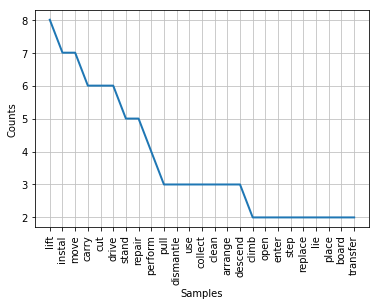

Total count for this dataset is 140


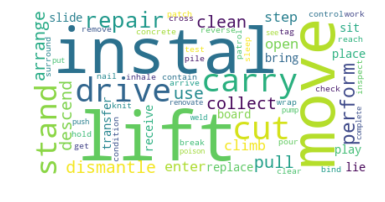



Caught in/between Objects


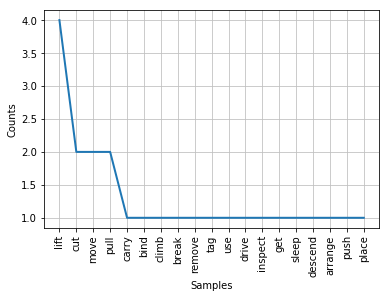

Total count for this category is 25


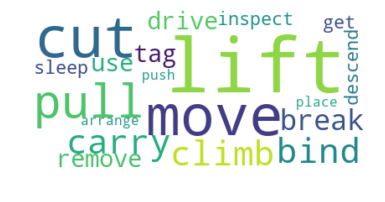

Top 5 activity word and their sentences


lift
====

lift the lifting tray
lifting lug
lifting works using Overhead Travelling Crane
lifting a Concrete Pile Head



cut
===

cutting down trees
cutting the trees



move
====

removing the glass door
moving brick trucks
moving downwards



pull
====

pulling out cages
pulling out the cages



carry
=====

carrying the job of binding Reinforcement Steel Cage


Falls


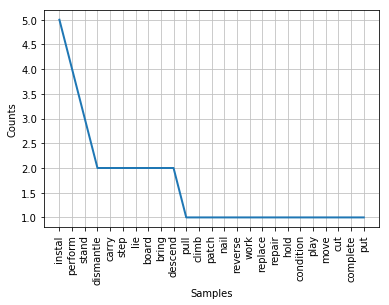

Total count for this category is 42


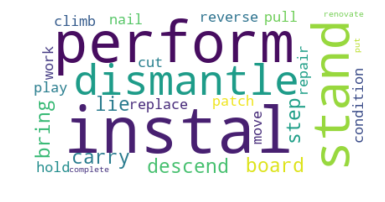

Top 5 activity word and their sentences


instal

installing roof trusses
installing the wall cladding
installing the roof
installing air conditioning pipes
installing water cooling cables



perform

performing cable pulling job
performing floor tiles installation
performing the installation of the working platform
performing the installation



stand
=====

standing on plywood plate
standing on the scaffolds
standing on a wagon



dismantle

dismantling Shear Wall
dismantling the scaffolding



carry
=====

carrying mold installation
carry out binding
carrying out T-Beam


Drowning


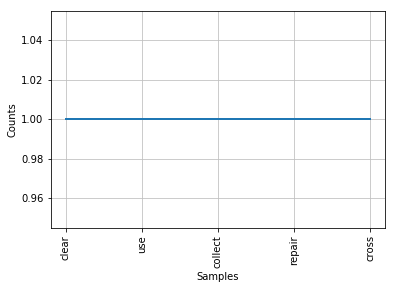

Total count for this category is 5


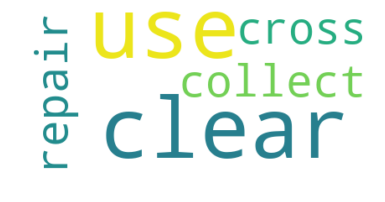

Top 5 activity word and their sentences


clear
=====

clearing work using bulldozer



use
===




collect

collecting water samples



repair

repairing a sand processing machine



cross
=====

crossing the river


Other


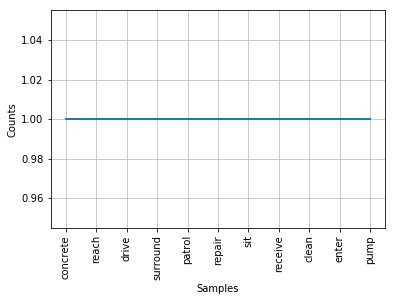

Total count for this category is 11


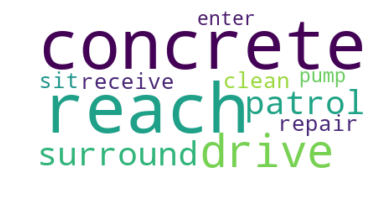

Top 5 activity word and their sentences


concrete

concreting the floor



reach
=====

reaching the control room



drive
=====

driving down a steep path



surround

surrounding earth afterwards



patrol

patroling the plantation


Struck By Moving Objects


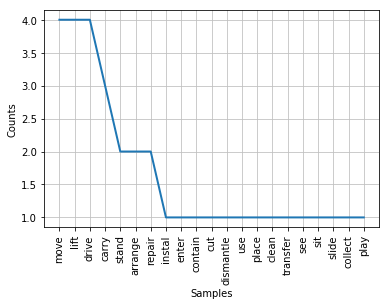

Total count for this category is 35


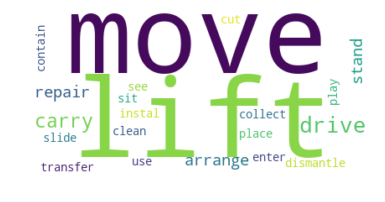

Top 5 activity word and their sentences


move
====

move the box containing foods
moving forklift
moving truck
moving the logs



lift
====

lifting a bundle
lifting a pile
lifting the drain block
lifting a load



drive
=====

driving downhill
driving uphill
driving up the steep road
driving a tractor
driving a tractor carrying earth



carry
=====

carrying road leveling work using steamroller
carrying out visual inspection



stand
=====

standing on the drawbar trailer
standing on the connection


Collapse of object


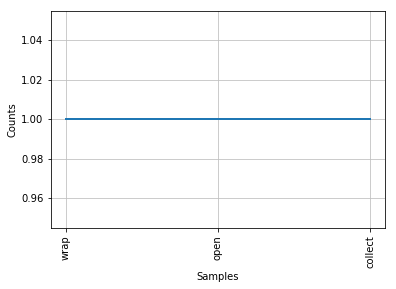

Total count for this category is 3


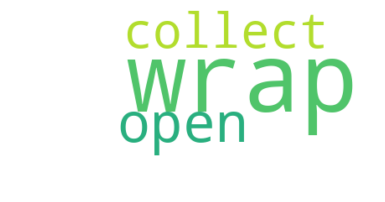

Top 5 activity word and their sentences


wrap
====

wrapping plastic tubing



open
====

opening the mold



collect

collecting cans


Fires and Explosion


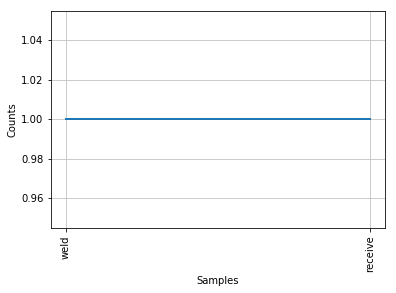

Total count for this category is 2


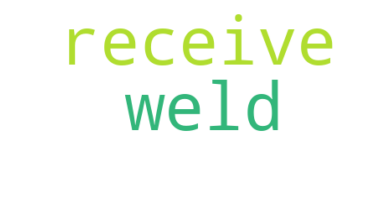

Top 5 activity word and their sentences


weld
====

welding the cover



receive

receiving treatment


Electrocution


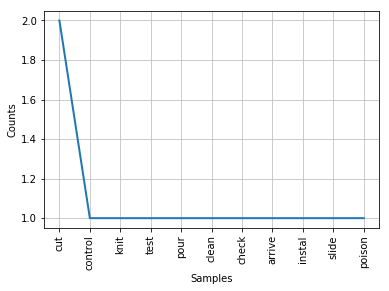

Total count for this category is 12


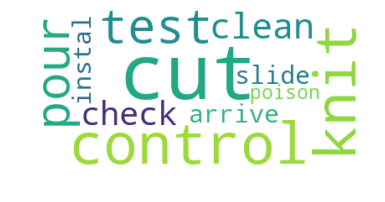

Top 5 activity word and their sentences


cut
===

cutting the oil palm fruit
cutting a cable



control

controlling the traffic



knit
====

knitting the oil palm fruits



test
====

testing the circuit



pour
====

pouring the concrete


Suffocation


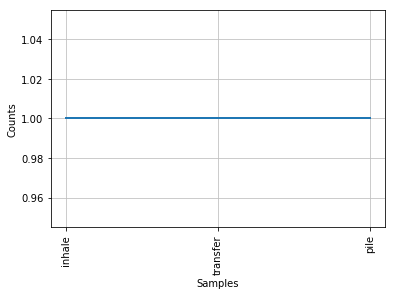

Total count for this category is 3


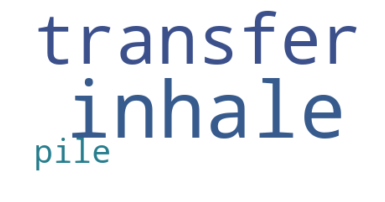

Top 5 activity word and their sentences


inhale

inhaling toxic gas while transfering schedule wastes



transfer




pile
====

piling machine


Exposure to Chemical Substances


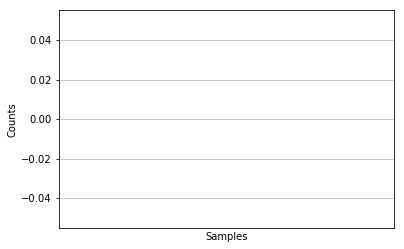

Total count for this category is 0


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [160]:
if ProcessMsiaDataSet:
    chunk_count = 0
    verb_count = 0
    VisualisationAll(MsiaCaseItems)
    for cat in MsiaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Msia Extraction Chunk Count is " +  str(chunk_count))
    print("Msia Extraction Verb Count is " +  str(verb_count)) 

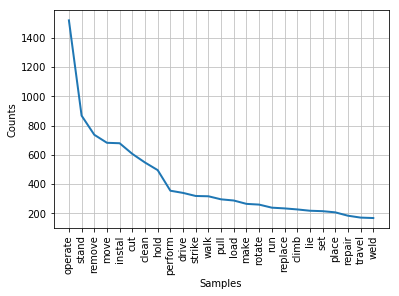

Total count for this dataset is 28260


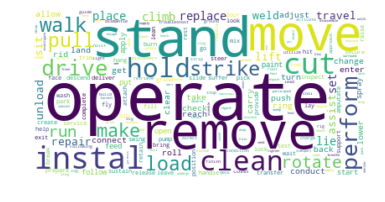



Caught in/between Objects


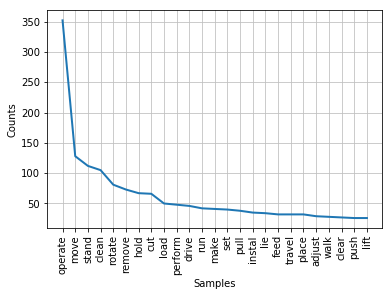

Total count for this category is 3764


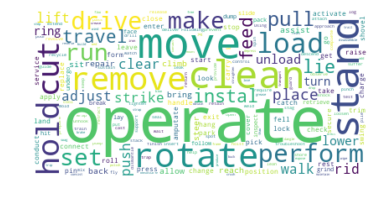

Top 5 activity word and their sentences


operate

operating a rough terrain forklift
operating an asphalt-pulverizing machine
operating a polypropylene filament extruder machine
operating the backhoe
operating a Lavina
operating an unfamiliar stand-up forklift
operating an E30 XL Hyster
operating a scissor lift
operating an aerial lift
operating a CNC lathe



move
====

moving boom section
removing the fifth beam
moving rough-top conveyor
moving tire
moving conveyor belt
moving conveyor belt
moving conveyor
removing safety brackets
moving the boom
moving rollers



stand
=====

standing on a portable ladder adjusting
standing platform
standing in front
standing near the tunnel entrance
standing in the basket
standing at the rear
standing at the front
standing in front
standing in front
standing on the pipe



clean
=====

cleaning photo sensor eyes
cleaning the build-up
cleaning the machine
cleaning the rag
cleaning the idler roll
cleaning rollers
cleaning a plastic grinding machine


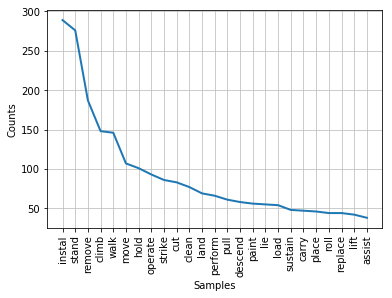

Total count for this category is 5692


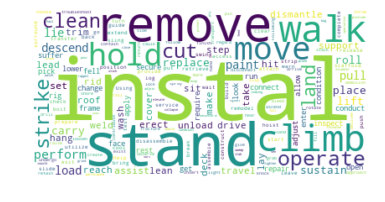

Top 5 activity word and their sentences


instal

installing vinyl sidings
installing roofing felt paper
installing Western Union Signs
installing an advertisement sign
installing the advertisement
installing curbing for the installation
installing fasteners
installing reinforcing bars
installing rigging equipment
install the rolled poly plastic over the existing plastic



stand
=====

standing an A-frame ladder
standing on the corner end
standing on a beam
standing on the skylight
standing atop a rice bin
standing in the bin
standing on unguarded ladder
standing on a FMC Commander
standing on the flatbed trailer
standing on gondola roofs



remove

remove a piece of roofing machinery
removing road construction warning signs
removing a number
removing wall-mounted triangular brackets
removing the almonds
removing a cover
removing flue gas tubes
removing tin roof panels
removing the ladder
removing asbestos containing material



climb
=====

climbing rope
climbing pegs
climbing tower


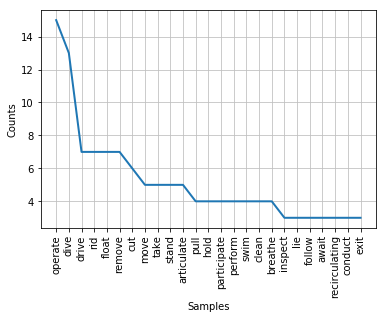

Total count for this category is 283


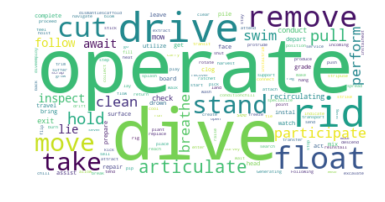

Top 5 activity word and their sentences


operate

operating a Link-Belt Crane
operating the Model Number D9H bulldozer
operating a D-9 dozer stock piling gravel
operating a John Deere Model Number200C LC excavator
operating the machine
operating a backhoe
operating a Yamaha BearTracker all-terrain vehicle
operating a Komatsu PC
operating a backhoe loader
operating a Ford



dive
====

diving operations
diving for sea urchins
diving equipment
diving partner/trainer
diving for sea urchins
diving employing a Huka device
diving equipment
diving helmet
diving helmet
diving underneath a casino barge



drive
=====

driving a John Deere tractor
driving a Kubota Model Number MX500
driving the tractor
driving under adverse weather conditions
driving on the road
driving the backhoe
driving on a dirt road



rid
===

riding a tractor John Deere Tractor
riding lawn mower
riding in a company vehicle
riding in a dump truck
riding lawn mower



float
=====

floating in the water
floating face
floati

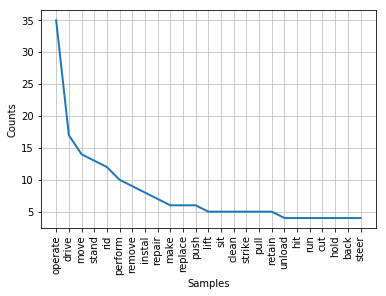

Total count for this category is 422


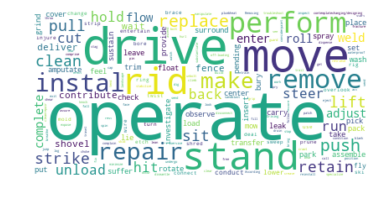

Top 5 activity word and their sentences


operate

operating a standup forklift
operating a backhoe
operating an electric forklift
operating a bobcat loader
operating an industrial truck
operating a box temper furnace
operating at the bottom
operating a rough terrain forklift
operating a 40-ton Lorain crane
operating other scissor lifts



drive
=====

driving the lift
driving a forklift
driving a vehicle
driving Employee
driving the lift
driving a REDI-LIFT Hydraulic truck crane
driving the aerial lift truck
driving the ATV
driving a Terex
driving a Toyota sit



move
====

moving pistons
moving a two-wheeled Kelco blasting pot
removing a hose
moving the cart
removing the nut
removing the wood material
moving the line
removing the defective component Employee
removing chains
removing a screw-on end cap nitrogen



stand
=====

standing on the skid
standing on the ground
standing on the side of the cooling table
standing position
standing near the end
standing on a stick
standing in fr

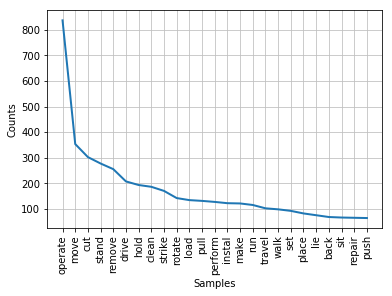

Total count for this category is 11075


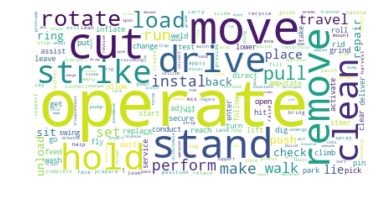

Top 5 activity word and their sentences


operate

operating a beet harvesting machine
operating a wire rope winding machine
operating the wire rope winder without wearing face protection
operating an Oakley
operating a Golf
operate a sandblasting pot
operating above the revolutions-per-minute
operating a Raymond Model Number
operating pallet jacks
operating an aerial lift



move
====

moving cans
moving components
remove the welding splatter
removing jet fuel emissions
removing an item
moving the cart
removing an air hose
move out of the way of the falling branch
removing mechanical equipment
moving part



cut
===

cutting the seal
cutting a third piece
cutting an aluminum sheet
cutting a metal railing
cutting through a knot
cutting torch
cutting down a eucalyptus tree
cutting the top
cutting the beam
cutting a piece



stand
=====

standing in front
standing in the front
standing in front
standing on the elevated lift platform
standing by a tree
standing near the handler
standing i

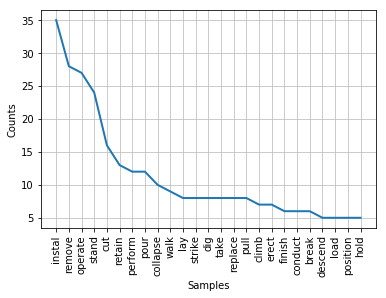

Total count for this category is 716


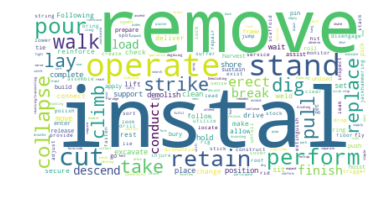

Top 5 activity word and their sentences


instal

installing the first stage
installing the advertising display
installing equipment
installing control
installing purlins
installing steel
installing a concrete form
installing the wall
installing guardrails
installing the last section



remove

removing branch cuttings
removing the old tile
removing old adhesive
removing the roof
removing a temporary wall
removing the top track
removing steel roofing panels
removing roof panel
removing the panel
removing a transmission



operate

operating the forklift
operating the forklift
operating an Eagle
operating a bull float
operating a backhoe
operating a front loader
operating a band saw
operating a skid-steer tractor
operating a Fraco
operating a VERSACRANE Model Number TC36000 crane



stand
=====

standing on an epoxy-coated dowel
standing on an extension ladder
standing on the front
standing on this section
standing on the roof
standing on a 1-inch by 4-inch catwalk
standing on top
stand

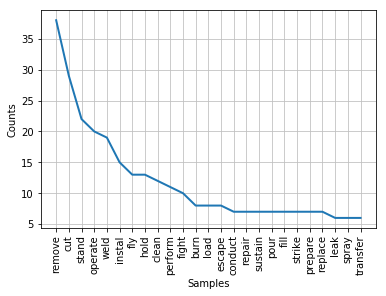

Total count for this category is 776


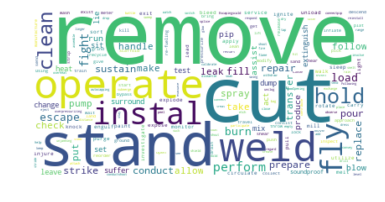

Top 5 activity word and their sentences


remove

removing a custom
removing rock gravel
removing the pipe stem
removing the nozzle
removing Accelerator P
removing the flange
removing the mill access doors
removing the door
removing the kinks
removing cores



cut
===

cutting torch
cutting grinding
cutting area
cutting area
cutting torch
cutting the device with a cutting torch
cutting torch
cutting torch
cutting torch
cutting torch



stand
=====

standing in an excavation
standing in the immediate area
standing on a platform
standing with the upper portion
standing at the rear
standing at the top
standing on the top edge
standing on planks
standing on the fourth floor landing
standing near the door



operate

operating a Maren model
operating the air valve
operating the choke
operating a vacuum truck
operating procedures
operating a blender
operating presses
operating the electronic firing
operating a gasoline
operating a ditching machine



weld
====

welding a shaft
welding torch


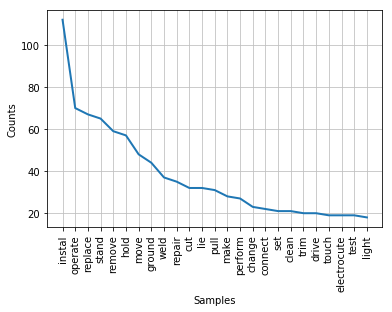

Total count for this category is 2272


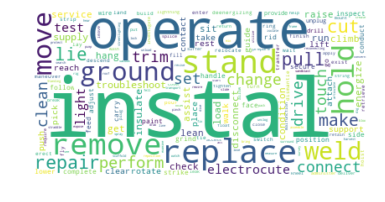

Top 5 activity word and their sentences


instal

installing a new light fixture
install metal sub-flooring
installing all dielectric self-supporting fiber-optic cable
installing additional cross braces
installing supporting braces
installing a thermostat line
installing a central air conditioner
installing an electric pole
installing an air conditioning unit
installing equipment



operate

operating the sandblasting equipment
operating a Bliss OBI
operating an asphalt roller
operating the asphalt roller
operating a Bobcat
operating an overhead crane
operating a tug
operating a pile driver
operating a soil auger
operating the auger



replace

replacing the rubber gasket
replacing the guide
replacing some poles
replacing the cover
replacing the ends
replacing light bulbs
replacing the ballast
replacing a ballast
replacing a ballast
replacing a power breaker cover



stand
=====

standing at the end
standing behind Employee
standing on a metal ventilation duct
standing on the shoulder


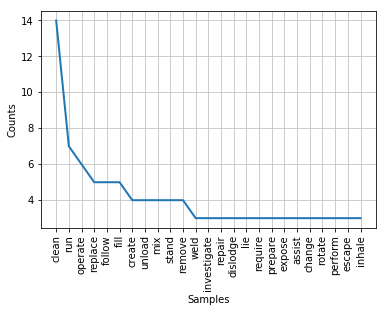

Total count for this category is 266


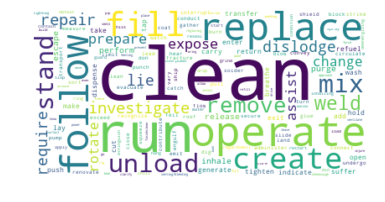

Top 5 activity word and their sentences


clean
=====

cleaning the HVAC system
cleaning up the leaking oil
cleaning up the leaking oil
cleaning equipment
cleaning dust
cleaning the Liebert air conditioning units
cleaning up from the evening meal
cleaning technician
cleaning tech
cleaning up the spill



run
===

running for cover
running water
running water
running off the sides
running on the mill
running polyvinyl chloride
running a piece



operate

operating gas forklifts
operating the main control device handles
operating each mixer
operating extruding
operating specifications
operating a LYCOFIT Model Number
operating a Caterpillar D-8 bulldozer
operating a manual choke
operating a Vac-U-Vator vaculator



replace

replacing a solenoid valve
replacing a valve
replacing empty EtO cylinders
replacing a sump pump
replacing an inoperative valve



follow

following the hose
following the maintenance activities
following an examination
following confined space procedures


Exposure t

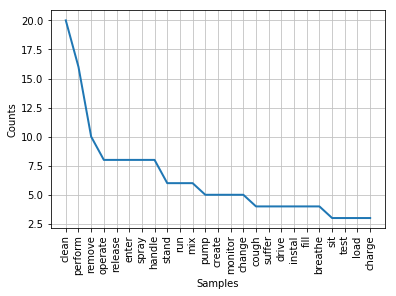

Total count for this category is 440


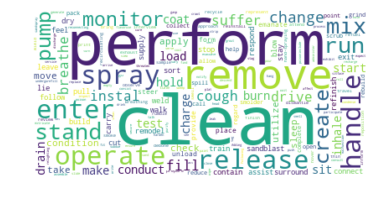

Top 5 activity word and their sentences


clean
=====

cleaning fluids
cleaning the floors
cleaning concrete
cleaning employee
cleaning the butcher block area
cleaning up a stadium
cleaning supplies
cleaning the lavatories
cleaning chemical
cleaning chemicals



perform

performing a fire watch
performing all maintenance
performing fluoride tests
performing mold inspections
performing routine maintenance
perform any monitoring
performing janitorial duties
performing the necessary steps
performing a routine task
performing a chemical transfer



remove

removing pool paint
remove the old coating
removing the hose
removing an I-beam
removing paint
removing a resin pin
removing liquid trichloroethylene
remove a cleaning system
removing stains
removing carpet



operate

operating industrial trucks
operating in the warehouse
operating this gasoline
operating manual specifies operating limits
operating a tanker truck
operating in the enclosed garage
operating a paper coating machine
operati

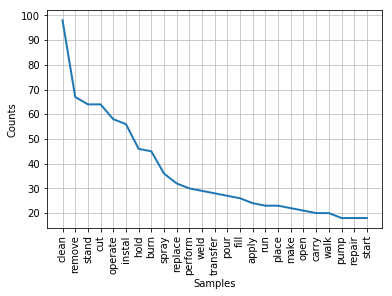

Total count for this category is 2554


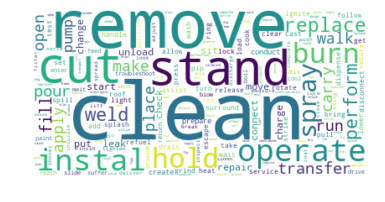

Top 5 activity word and their sentences


clean
=====

cleaning the interior
cleaning gypsum
cleaning the interior
cleaning the tank Employee
cleaning with acetone
cleaning a separation tank
cleaning with a rag
cleaning out metal shavings
cleaning ground aluminum particles
cleaning miscellaneous material



remove

removing material
removing rubber hoses
removing a bearing
removing the filter canisters
removing a manufactured part
removing locking pins
removing a temporary electric service
removing racks
removing the second main fuse
removing the pump



stand
=====

standing in front
standing by the suction valve
standing by the side
standing on south side
standing north
standing near the unit
standing at the base
standing on the ground
standing near the rear driver
standing outside the hopper



cut
===

cutting a pipe
cutting the well
cutting the well casing
cutting torch
cutting torch
cutting tip
cut a hole into an existing injection
cutting an empty VMP Naphtha drum
cutting torch


In [187]:
if ProcessOshaDataSet:
    chunk_count = 0
    verb_count = 0
    VisualisationAll(OshaCaseItems)
    for cat in OshaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Osha Extraction Chunk Count is " +  str(chunk_count))
    print("Osha Extraction Verb Count is " +  str(verb_count))       

# Output to excel file with new additional columns for activity and activity chunks

In [188]:
#Write to excel with the additional columns for activity verb 
if ProcessMsiaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in MsiaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    MsiaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    MsiaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('MsiaWithActivity.xlsx',MsiaCasesDF)

if ProcessOshaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in OshaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    OshaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    OshaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('OshaWithActivity.xlsx',OshaCasesDF)


# Notes and Observation: 
- For the Msia dataset which is used as training dataset, the summary columns are mostly made up of complete grammatically sound sentences and thus the regular expression parser method is chosen to extract the activity phrases.

- For Msia dataset there's only 240 records, so we have a rather small dataset for training. Also, Msia dataset only have Summary column whereas Osha has a more detailed Descrition column.

- For Osha, we were able to extract out 28260 activities. This could mean for each column more than 1 activity (most likely a series of activity) taking place prior to the accident since total records in the dataset is 16003.

- In some sentences, for example, the actually activity is "handling maintenance work", thus the actual activity is maintenance work but because the regular expression parser is designed to extract the verb activity resulted in "handling" being captured instead of "maintaining" and results in a less than accurate description of the activity extracted from the dataset.

- Further improvements: Some of the activities captured are actually describing the cause of the incident, thus in order to get a more accurate text mining on activities, prior domain knowledge on what is considered cause and what is activities need to be incorporated.